# 30254 - ML for Public Policy HW4 - Nora Hajjar

## HW Assignment 4 - Clustering: 

The goal of this homework assignment is to build an interactive clustering tool. 

Coding Assignment:
Develop a data exploration notebook that is interactive and uses clustering methods. Feel free
to just use k-means for this homework.
The functionality should include:
1. load data from a csv
2. process the data so it’s ready for clustering
3. Given a k, generate k clusters using one of the clustering methods (k-means is fine for this)
4. For each cluster:
A. Provide summary stats for the cluster
B. Describe (using statistics, graphs, or any other visualizations) what types of data
points are in this cluster
C. what are the distinctive features of data points in this cluster (you might want to use
decision trees here)
5. Allow the user to
A. merge several clusters into one
B. recluster with a new k
C. Split a specific cluster into many (with a specific number of new clustering)
Analysis:
Data: projects_2012_2013.csv
6. Once you've set up clustering code, you should apply it to the data from the previous
homework to understand what types of projects are submitted added and also what type of
projects are predicted as high risk of not getting fully funded (output of your last homework).
Report:
You should also write a short report (1-2 pages) that describes what types of clusters you found
and what were the characteristics of projects in those clusters for:
1. the overall submitted projects
2. the top 5% of predicted projects from your test set that were not likely to be fully funded by
your model.

In [68]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
import final_pipeline as p
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline
from sklearn.cluster import KMeans, MeanShift, DBSCAN

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 1) load data from a csv

In [14]:
df = p.load_data('projects_2012_2013.csv')

### 2) process the data so it’s ready for clustering

In [15]:
#show null counts
null_counts = p.check_null_counts(df)
null_counts

projectid                                     0
teacher_acctid                                0
schoolid                                      0
school_ncesid                              9233
school_latitude                               0
school_longitude                              0
school_city                                   0
school_state                                  0
school_metro                              15224
school_district                             172
school_county                                 0
school_charter                                0
school_magnet                                 0
teacher_prefix                                0
primary_focus_subject                        15
primary_focus_area                           15
secondary_focus_subject                   40556
secondary_focus_area                      40556
resource_type                                17
poverty_level                                 0
grade_level                             

In [16]:
#drop columns that are irrelevant/too many nulls
df.drop(['school_ncesid', 'school_metro', 'secondary_focus_subject', 'secondary_focus_area'], axis=1, inplace=True)

In [17]:
#drop NA values for columns we can't fill in with avg
df.dropna(subset=['primary_focus_subject', 'primary_focus_area','resource_type', 'grade_level', 'school_district'], inplace=True)

In [18]:
#rest of nulls we will fill in after train/test splits 
#b/c numeric so we can fill in with avg
null_counts = p.check_null_counts(df)
null_counts

projectid                                  0
teacher_acctid                             0
schoolid                                   0
school_latitude                            0
school_longitude                           0
school_city                                0
school_state                               0
school_district                            0
school_county                              0
school_charter                             0
school_magnet                              0
teacher_prefix                             0
primary_focus_subject                      0
primary_focus_area                         0
resource_type                              0
poverty_level                              0
grade_level                                0
total_price_including_optional_support     0
students_reached                          53
eligible_double_your_impact_match          0
date_posted                                0
datefullyfunded                            0
dtype: int

In [19]:
#convert the dates to the appropriate type
p.convert_to_datetime(df, ['date_posted', 'datefullyfunded'])
df.dtypes

projectid                                         object
teacher_acctid                                    object
schoolid                                          object
school_latitude                                  float64
school_longitude                                 float64
school_city                                       object
school_state                                      object
school_district                                   object
school_county                                     object
school_charter                                    object
school_magnet                                     object
teacher_prefix                                    object
primary_focus_subject                             object
primary_focus_area                                object
resource_type                                     object
poverty_level                                     object
grade_level                                       object
total_price_including_optional_

In [20]:
#create our date_diff column
df['days_to_funded'] = df.datefullyfunded - df.date_posted

In [21]:
p.convert_column_type(df, 'days_to_funded', 'timedelta64[D]')

In [22]:
df['not_fully_funded_60'] = df['days_to_funded'] > 60.0

In [23]:
df['not_fully_funded_60'] = df['not_fully_funded_60'] * 1

In [35]:
#clean train/test data
cat_cols = ['school_state', 'school_city', 'school_district', 'school_county', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level']
disc_cols = ['total_price_including_optional_support', 'students_reached']
p.clean_data([df], cat_cols, disc_cols)



In [36]:
df

projectid                    teacher_acctid  \
0       00001ccc0e81598c4bd86bacb94d7acb  96963218e74e10c3764a5cfb153e6fea   
1       0000fa3aa8f6649abab23615b546016d  2a578595fe351e7fce057e048c409b18   
2       000134f07d4b30140d63262c871748ff  26bd60377bdbffb53a644a16c5308e82   
3       0001f2d0b3827bba67cdbeaa248b832d  15d900805d9d716c051c671827109f45   
4       0004536db996ba697ca72c9e058bfe69  400f8b82bb0143f6a40b217a517fe311   
5       00049ec8ca1f2d08cb13cab31b0b85ec  7149611553c700de9a6099f8a9ce598b   
6       0004d2fdbb571237fa53a97e7691440b  926671e209fb977bd5123145c1848ad1   
7       0004ee26667e751dd51384eb9f30c72e  abe4dabb7864f4c548d230cf9070e03f   
8       0006a31d45f8d52d217e7c5b55c11f37  3b5fada1ad0e339acc669829071320c4   
9       0008ac907bf237a15a959244205d3ee5  92527a5ac5fe946ed1961fb2e1de8cc5   
10      0009bc936fed4728d5fd86d92ee3cec1  66b77e507a30a5fbbcb4f7631c5ccc75   
11      000a6dcbb21ec643daf74ed28991d29c  93e0a37fca3cd7c9c32a535673c48af4   
12      000a981e6bd61c489bbebc237f7b6a0d  a886a532c21f83b0c30571208636dc0e   
13      000b238b8c85214d58683b13398fd058  439f1e081199a89540cbf69866cfd182   
14      000b574223b4f491c7de7bccae88b51d  5003eacb7e6311d01177c275c633768a   
15      000bab2056ba84931f4f5bc72f542e03  10d2de84406c94967bb0f01f57ba980f   
16      000be0b57987d6c29d650a88eac2961b  ae7b6b599922817b2e0cb9f96354297e   
17      000d3ead6b648ba31043bb6376e6342d  3dd9af5310c77541f5b65cf190cec338   
18      000e6a13fd69bf0e426403b1d5da0e99  1ad348085983de6a0f1fe6a37779f7f2   
19      000e964b1e5c911adf700736c43e8f85  27076f8d0ec597bfd5035ef84d6691b0   
20      000faa31e276e9e649360949207fa00c  86403b5f04ed07201cd04184ff4c0ced   
21      0010040593d5e9699ee45834369ec817  1871e44279646e8d18fa74d29dcfc456   
22      00103b0614e31016e5c4cc7d405bbc51  9e4433fb2d3078bc4dcbe2860d05ebf5   
23      00105edf14ebb7f146d6ba2098639bb1  ac1ef23232ddd1597f6fa5b28a171fa5   
24      001096473792e89ccc83e9f6ab01871b  e21c4208e61018ed35aa2bcc392a2d40   
25      00134d14226ef613134712c54211f754  5bce35e3991721b665d33095e9d3aa31   
26      00136585c0e4a67afaa964403cf9f45b  402cfc6b73dc62f44946bc1c381f6b1c   
27      0013a402fb4cf84e3d60d7a59566dff8  511ec2a1372cd7b9e1af86b1b3de8bff   
28      001468d419e1ee737f364013334d0c84  ca8d614f79013690baf1a8860be4b754   
29      0014cedcb2d697902c15081ab12deadf  b9e31d1b986c0cf802c9e13869b86cef   
...                                  ...                               ...   
124946  fff008ba1051b272f9e5218b1c125169  4999b5d89891ff2279c63e8f529f00ea   
124947  fff025ce2682430f72e02a7823c1c27b  67f274a673108b021563e4fb172371ea   
124948  fff0ce1935052d50a4485bd480db03a6  1533c37c1d202411324cdd2274777580   
124949  fff17ba5f8954c060395735b111edb96  490d0b530daeed042a70a2acc2be1dc7   
124950  fff1cbf1b7b26568ba57bb92992048b9  77c16c5f82bc583d9b13a3404f2daa37   
124951  fff213f5fb0e61d1ea9df3f992d54d6c  b69405d095b441c64c8d41dbbbab83c1   
124952  fff24308118daa069f765ad2662234a6  855f5bbf58e3fcf59583777027329c6a   
124953  fff2880da80e1b5443c838599d92e95d  ce2367ccff54254c79a79bf09bcf32ed   
124954  fff2f8b3170013ecf9ee7304c7b0d6d7  d728647826402b266ae8dc0d40914ebd   
124955  fff309b22dacd7a37db9cb9ccee1e031  15969f9fd415e45316f5df1e4f6f7114   
124956  fff3183fb122c03321ce10b81fda2f55  afdfef895e4033893531858b3b7b93e4   
124957  fff427a481a6ae0da7c79ee3a568a25d  2f4d0c10a6c3b90c1cdf700c1d1e8783   
124958  fff43d73c89c9c0fa3455f71f36846af  c3892f47501ebe7560bb47f044cb6c1a   
124959  fff4a452b872e91d3953849c26d66762  157dec98e29ea71d21c757c3b5d7807f   
124960  fff50452c8b57fabd715d5547997d659  a3b0edce360c46d821f3f949c37e0760   
124961  fff5d11155a3d8e8c56a41fb2e79912c  442cff1ac9ba42e5dfcbbe3d924f4c07   
124962  fff5fd6f1a382a7a9ceff838f35212e1  987a7ad70c7f28fb06e969a3a3bfbb08   
124963  fff8e52c5aac56e34c4d4eb5aa443c5d  9ed92b421feff227841dbe235da3a09c   
124964  fff8ea691f0be0e4ed486690eb56c14f  c530d7baec513b17570c7ea40df638e9   
124965  fffa75021cdd838e658b331847c78ad2  bd202f86ad8

### 3) Given a k, generate k clusters using one of the clustering methods (k-means is fine for this)

In [109]:
dep_var = 'not_fully_funded_60'
pred_vars = ['total_price_including_optional_support',
        'students_reached',
       'eligible_double_your_impact_match', 
       'school_state',
       'school_city', 
       'school_district', 
       'school_county',
       'school_charter', 
       'school_magnet', 
       'teacher_prefix',
       'primary_focus_subject', 
       'primary_focus_area',
       'resource_type', 
       'poverty_level', 
       'grade_level']

In [169]:
X = df[['total_price_including_optional_support',
        'students_reached',
       'eligible_double_your_impact_match', 
       'school_state',
       'school_city', 
       'school_district', 
       'school_county',
       'school_charter', 
       'school_magnet', 
       'teacher_prefix',
       'primary_focus_subject', 
       'primary_focus_area',
       'resource_type', 
       'poverty_level', 
       'grade_level', 'not_fully_funded_60']]
km = KMeans(n_clusters=4,  init='random', n_init=1 , max_iter = 1, random_state=1)
km_fit = km.fit(X)

In [181]:
centroids = km.cluster_centers_
centroids

array([[ 1.89840805e-04,  8.13603450e-05,  3.27665229e-01,
         1.86502319e+01,  3.47211946e+03,  3.31100103e+03,
         7.36035229e+02,  1.12168796e-01,  8.24722697e-02,
         2.26575001e+00,  1.49122935e+01,  3.30995579e+00,
         1.91977870e+00,  1.02682179e+00,  1.59547636e+00,
         2.95880455e-01],
       [ 1.00118474e-04,  8.34320613e-05,  2.87206528e-01,
         2.23199620e+01,  1.52779215e+03,  1.86107504e+03,
         6.21137980e+02,  7.39374927e-02,  9.41781108e-02,
         2.25957383e+00,  1.49804102e+01,  3.35610472e+00,
         1.87605333e+00,  1.07362045e+00,  1.56885648e+00,
         2.90827479e-01],
       [-1.16958309e-17, -2.96800345e-18,  2.35254989e-01,
         2.16965632e+01,  5.09012406e+03,  5.21152095e+03,
         6.46359534e+02,  8.42572062e-02,  5.93126386e-02,
         2.22605322e+00,  1.48850333e+01,  3.31851441e+00,
         1.84955654e+00,  1.14124169e+00,  1.60731707e+00,
         2.60643016e-01],
       [ 5.27370531e-05, -2.78233383e

In [187]:
y = km.predict(X)
y

array([1, 2, 0, ..., 2, 0, 0], dtype=int32)

TypeError: unhashable type: 'numpy.ndarray'

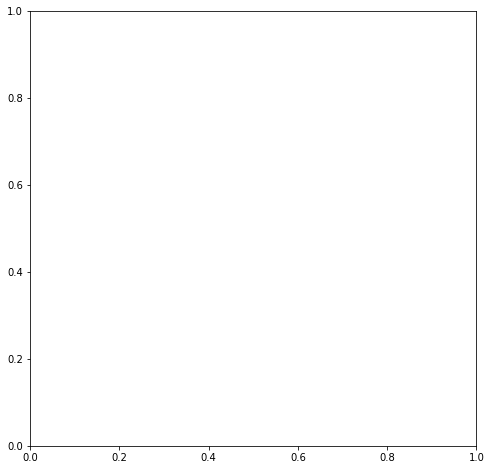

In [172]:
cluster_df = pd.DataFrame()
for index, colname in enumerate(list(X)):
    cluster_df[colname] = X[colname]
cluster_df['n_cluster_group'] = km_fit.labels_
cluster_df



total_price_including_optional_support students_reached  \
0                                           0                0   
1                                           0                0   
2                                           0                0   
3                                           0                0   
4                                           0                0   
5                                           0                0   
6                                           0                0   
7                                           0                0   
8                                           0                0   
9                                           0                0   
10                                          0                0   
11                                          0                0   
12                                          0                0   
13                                          0                0   
14                                          0                0   
15                                          0                0   
16                                          0                0   
17                                          0                0   
18                                          0                0   
19                                          0                0   
20                                          0                0   
21                                          0                0   
22                                          0                0   
23                                          0                0   
24                                          0                0   
25                                          0                0   
26                                          0                0   
27                                          0                0   
28                                          0                0   
29                                          0                0   
...                                       ...              ...   
124946                                      0                0   
124947                                      0                0   
124948                                      0                0   
124949                                      0                0   
124950                                      0                0   
124951                                      0                0   
124952                                      0                0   
124953                                      0                0   
124954                                      0                0   
124955                                      0                0   
124956                                      0                0   
124957                                      0                0   
124958                                      0                0   
124959                                      0                0   
124960                                      0                0   
124961                                      0                0   
124962                                      0                0   
124963                                      0                0   
124964                                      0                0   
124965                                      0                0   
124966                                      0                0   
124967                                      0                0   
124968                                      0                0   
124969                                      0                0   
124970                                      0                0   
124971                                      0                0   
124972                                      0                0   
124973                                      0                0   
124974                                      0  

In [173]:
n_clusters = cluster_df.n_cluster_group.unique().tolist()
n_clusters

[1, 2, 0, 3]

### For each cluster:

### A. Provide summary stats for each cluster
### B. Use graphs to describe what types of data points are in this cluster

cluster_group: 1
       eligible_double_your_impact_match  school_state   school_city  \
count                       52271.000000  52271.000000  52271.000000   
mean                            0.285225     22.424499   1306.305619   
std                             0.451526     14.638996    895.082461   
min                             0.000000      0.000000      0.000000   
25%                             0.000000      9.000000    604.000000   
50%                             0.000000     22.000000   1064.000000   
75%                             1.000000     34.000000   1986.000000   
max                             1.000000     50.000000   4377.000000   

       school_district  school_county  school_charter  school_magnet  \
count     52271.000000   52271.000000    52271.000000   52271.000000   
mean       1800.897171     596.943085        0.073922       0.096727   
std        1246.509120     370.579178        0.261647       0.295588   
min           0.000000       0.000000        0

cluster_group: 3
       eligible_double_your_impact_match  school_state   school_city  \
count                       18390.000000  18390.000000  18390.000000   
mean                            0.283796     19.623545   4600.116476   
std                             0.450851     15.682700    649.453821   
min                             0.000000      0.000000   2055.000000   
25%                             0.000000      4.000000   4154.000000   
50%                             0.000000     17.000000   4636.000000   
75%                             1.000000     36.000000   4969.000000   
max                             1.000000     50.000000   5950.000000   

       school_district  school_county  school_charter  school_magnet  \
count      18390.00000   18390.000000    18390.000000   18390.000000   
mean        4117.99391     960.306199        0.107613       0.079554   
std          692.92003     290.963160        0.309899       0.270609   
min         1872.00000       3.000000        0

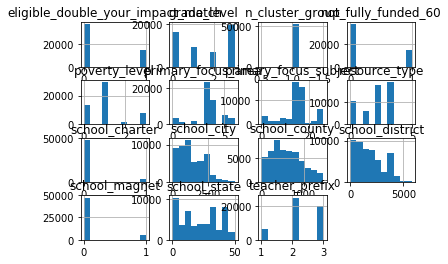

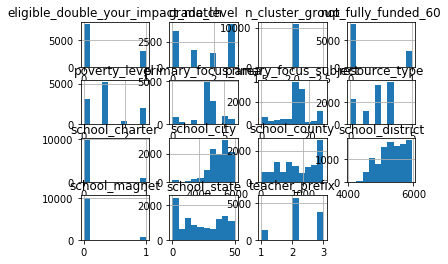

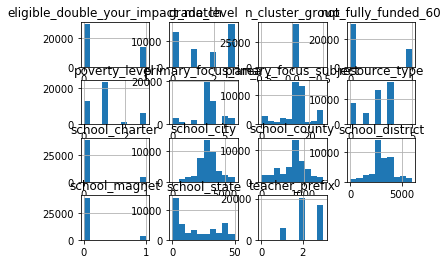

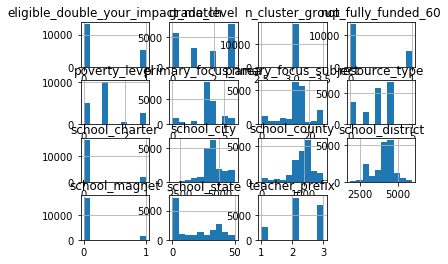

In [198]:
#see summary stats and histograms for part A and B below
for n in n_clusters:
    cluster = cluster_df[cluster_df['n_cluster_group'] == n]
    print('cluster_group:', n)
    print(cluster[cluster.columns].describe())
    cluster.hist()

### B. Use stats/graphs etc to describe what types of data points are in this cluster

### C. What are the distinctive features of data points in this cluster? (Use decision trees)

###

### CREATE TEMPORAL VALIDATION TEST/TRAIN SPLITS

In [29]:
#automated method, based on Rayid function
#switched from manual process

#Guidelines for Analysis - from Rayid:
#training 1: 1/1/2012 to 4/30/2012 (leave 60 days to see result of training data) 
#test 1: 7/1/2012 to 10/31/2012
#training 2: 1/1/2012 to 10/31/2012
#test 2: 1/1/2013 to 4/30/2013
#training 3: 1/1/2012 to 4/30/2013
#test 3: 7/1/2013 to 10/31/2013

splits = p.temporal_splits('2012-01-01', '2013-12-31', [6], 60)

In [30]:
#split the data into train/test dfs based on the temporal splits above
train_test_dfs = p.temporal_split_train_test_dfs(df, splits)

#now we have a list of train/test dataframes 
#(6 total, based on the temporal validation groups that we have - 3 train, 3 test)
#time to pre-process the data before it goes into the models

In [31]:
#clean train/test data
cat_cols = ['school_state', 'school_city', 'school_district', 'school_county', 'teacher_prefix', 'primary_focus_subject', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level']
disc_cols = ['total_price_including_optional_support', 'students_reached']
p.clean_data(train_test_dfs, cat_cols, disc_cols)

In [48]:
#set the dep_var and pred_vars
dep_var = 'not_fully_funded_60'
pred_vars = ['total_price_including_optional_support', 
        'students_reached',
       'eligible_double_your_impact_match', 
       'school_state',
       'school_city', 
       'school_district', 
       'school_county',
       'school_charter', 
       'school_magnet', 
       'teacher_prefix',
       'primary_focus_subject', 
       'primary_focus_area',
       'resource_type', 
       'poverty_level', 
       'grade_level']

### RUN THE MODELS, OUTPUT RESULTS

In [62]:
#parameters
#RUN THIS - SMALLER 

clfs = {
		'BG': BaggingClassifier(n_estimators=10),
		'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
		'LR': LogisticRegression(penalty='l1', C=1e5),
		'SVM': svm.LinearSVC(random_state=0, penalty='l1', dual=False),
		'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
		'DT': DecisionTreeClassifier(),
		'KNN': KNeighborsClassifier(n_neighbors=3),
		'NB': GaussianNB()}

grid = {
		'BG': {'n_estimators': [10,50]}, 
		'RF': {'n_estimators': [1,10], 'max_depth': [1,5,10], 'max_features': ['sqrt','log2']},
		'LR': { 'penalty': ['l1','l2'], 'C': [0.01,0.1,1,10]},
		'GB': {'n_estimators': [1,10], 'learning_rate' : [0.05,0.1],'subsample' : [0.5,1.0], 'max_depth': [10,20]},
		'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5]},
		'SVM':{'penalty':['l1','l2'], 'C' :[0.01,0.1,1]},
		'KNN':{'n_neighbors': [5,10],'weights': ['uniform','distance']},
		'NB': {}
		}
    
models_to_run = ['RF', 'DT', 'GB', 'SVM', 'KNN', 'LR', 'BG']


train_test_data_period_1
RF


/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

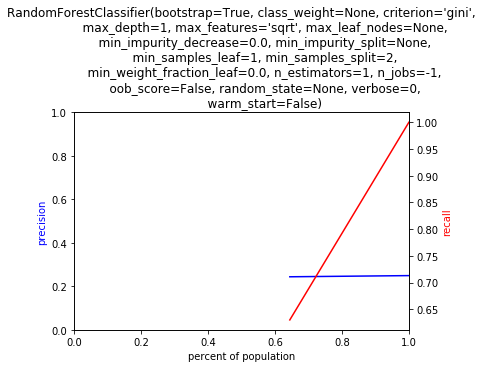

<Figure size 432x288 with 0 Axes>

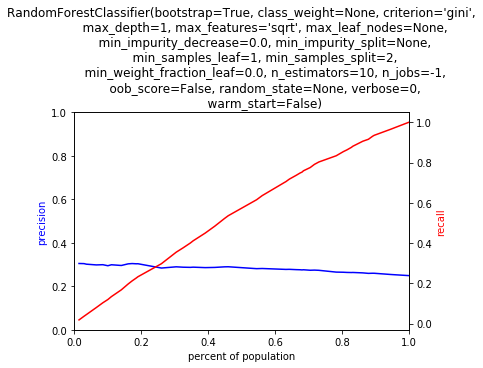

<Figure size 432x288 with 0 Axes>

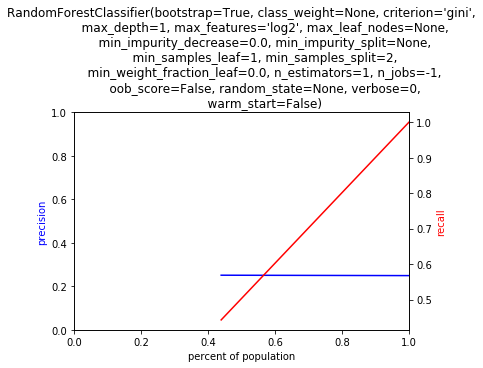

<Figure size 432x288 with 0 Axes>

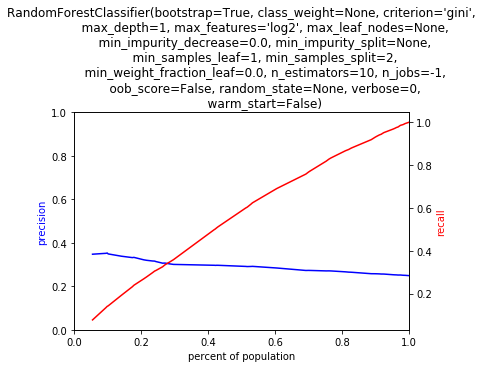

<Figure size 432x288 with 0 Axes>

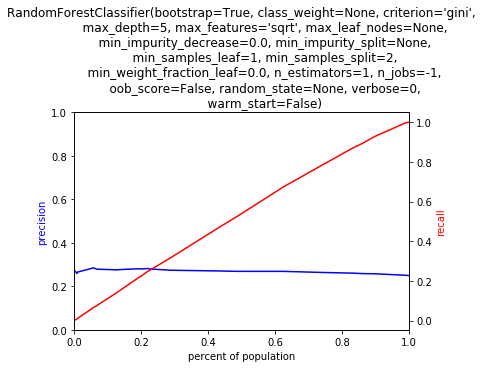

<Figure size 432x288 with 0 Axes>

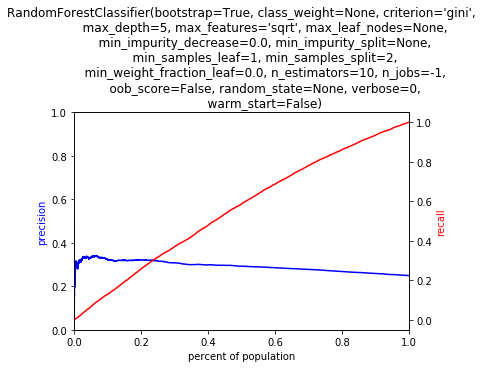

<Figure size 432x288 with 0 Axes>

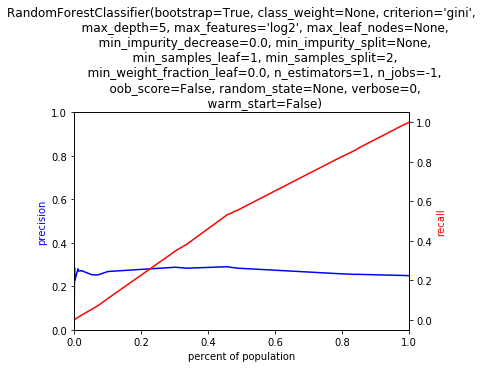

<Figure size 432x288 with 0 Axes>

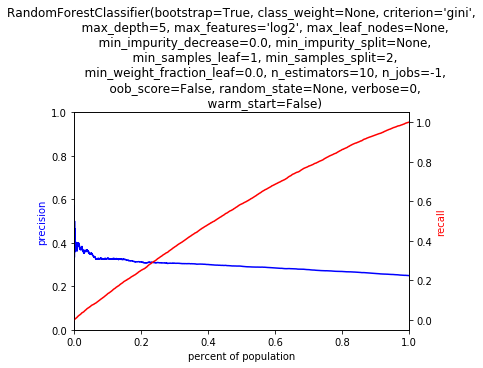

<Figure size 432x288 with 0 Axes>

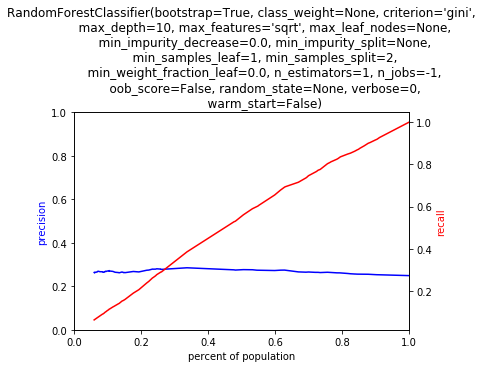

<Figure size 432x288 with 0 Axes>

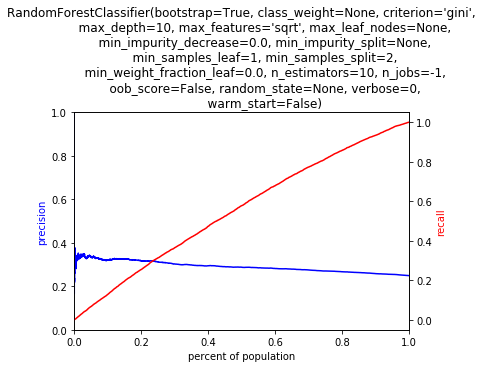

<Figure size 432x288 with 0 Axes>

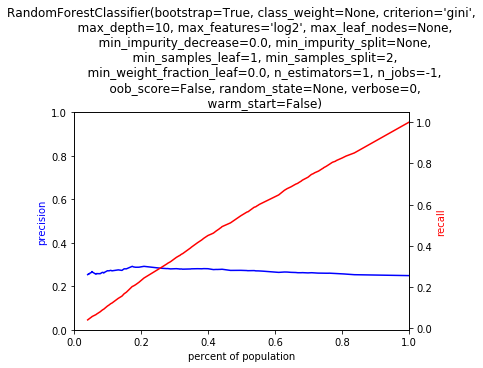

<Figure size 432x288 with 0 Axes>

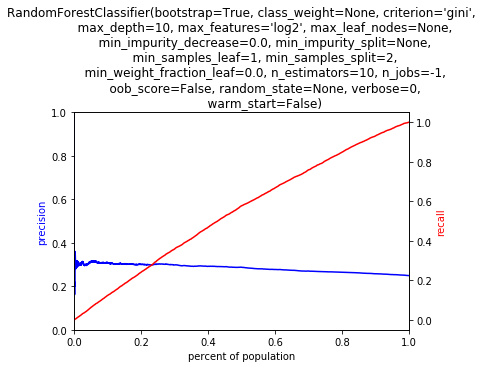

DT


/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

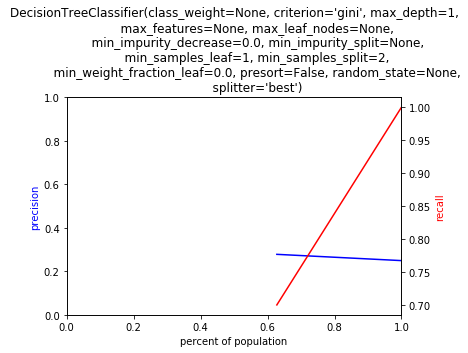

<Figure size 432x288 with 0 Axes>

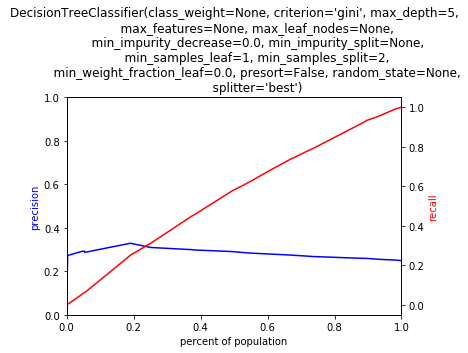

/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

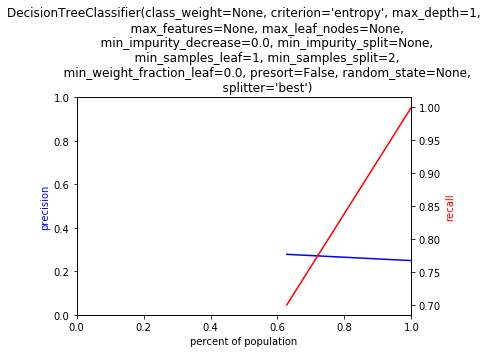

<Figure size 432x288 with 0 Axes>

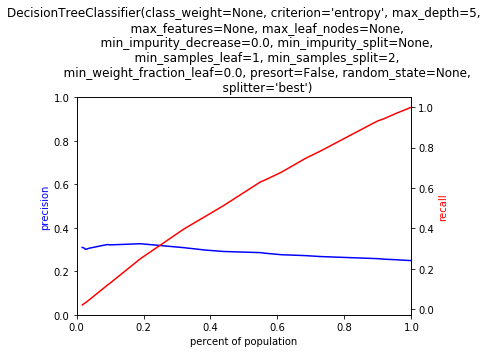

GB


<Figure size 432x288 with 0 Axes>

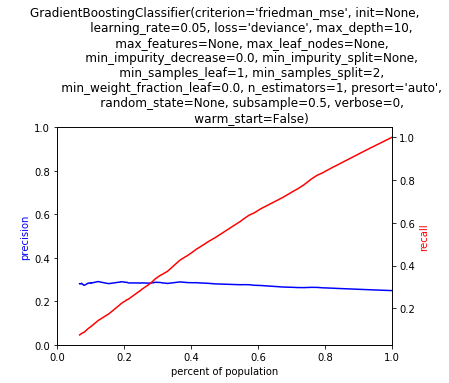

<Figure size 432x288 with 0 Axes>

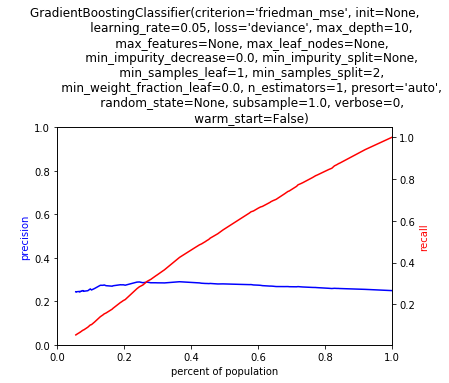

<Figure size 432x288 with 0 Axes>

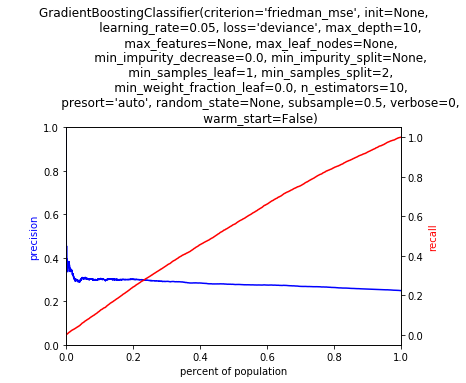

<Figure size 432x288 with 0 Axes>

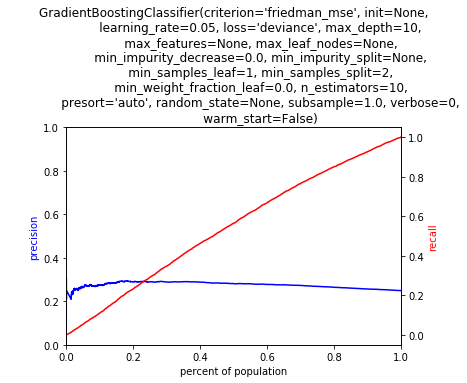

<Figure size 432x288 with 0 Axes>

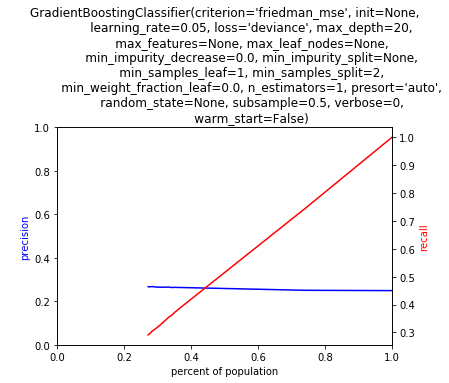

<Figure size 432x288 with 0 Axes>

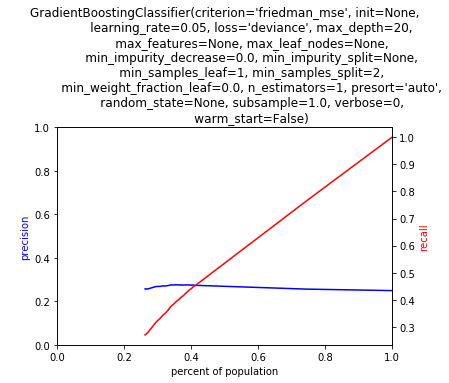

<Figure size 432x288 with 0 Axes>

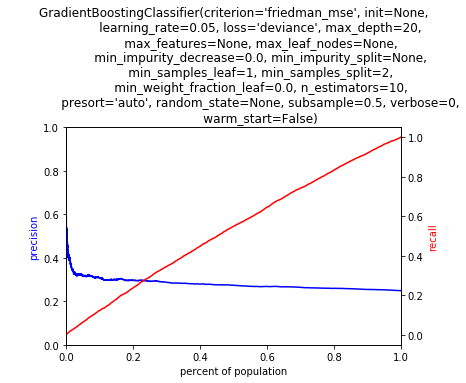

<Figure size 432x288 with 0 Axes>

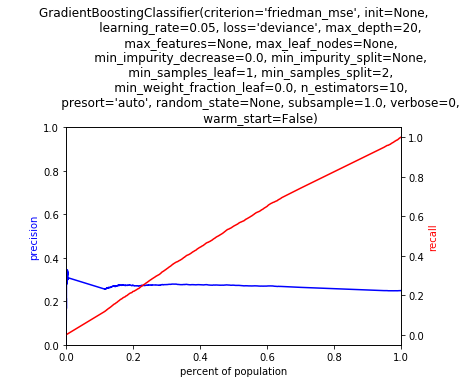

<Figure size 432x288 with 0 Axes>

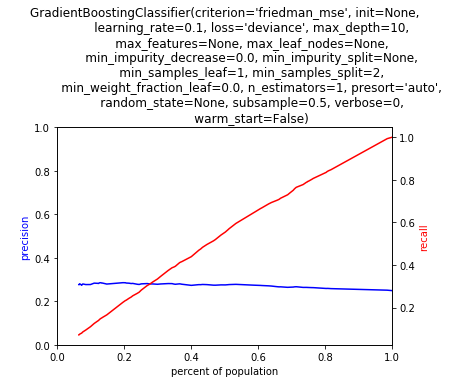

<Figure size 432x288 with 0 Axes>

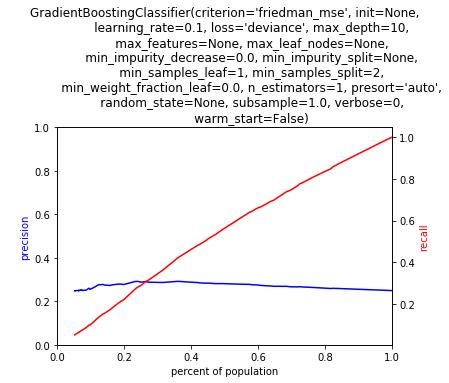

<Figure size 432x288 with 0 Axes>

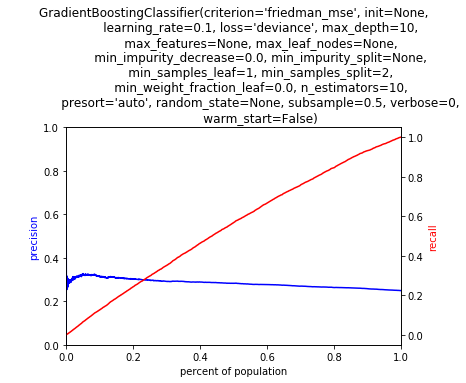

<Figure size 432x288 with 0 Axes>

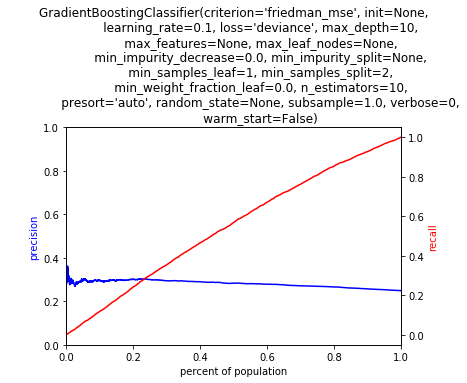

<Figure size 432x288 with 0 Axes>

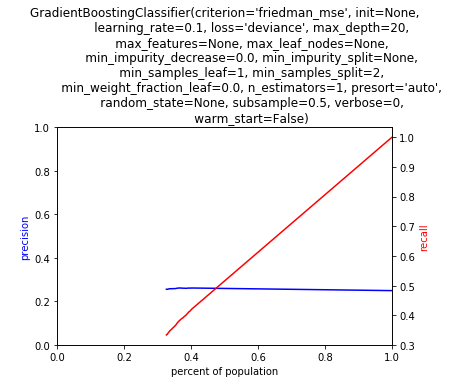

<Figure size 432x288 with 0 Axes>

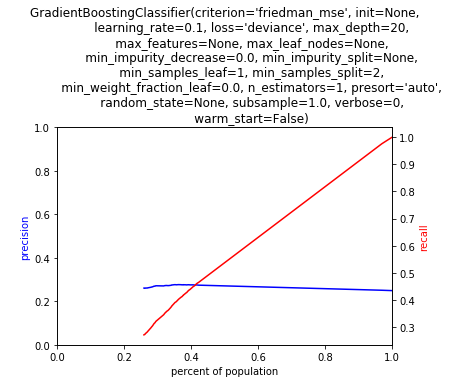

<Figure size 432x288 with 0 Axes>

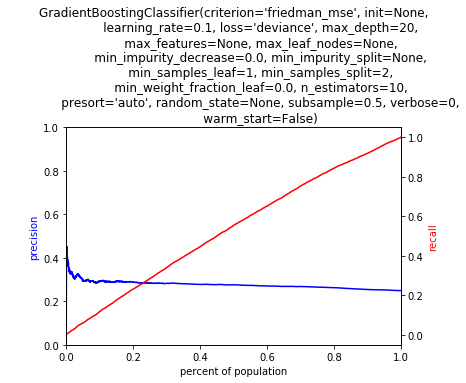

<Figure size 432x288 with 0 Axes>

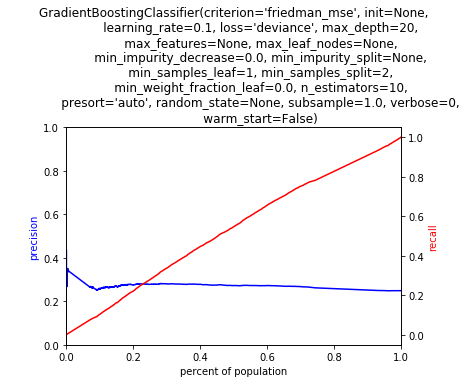

SVM


<Figure size 432x288 with 0 Axes>

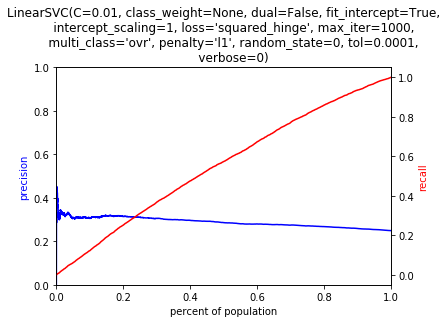

<Figure size 432x288 with 0 Axes>

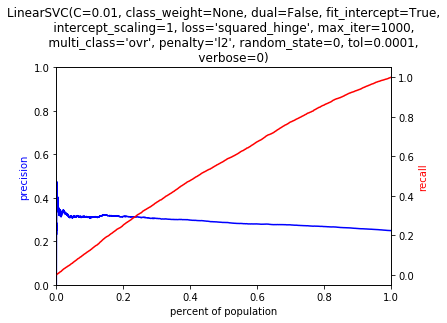

<Figure size 432x288 with 0 Axes>

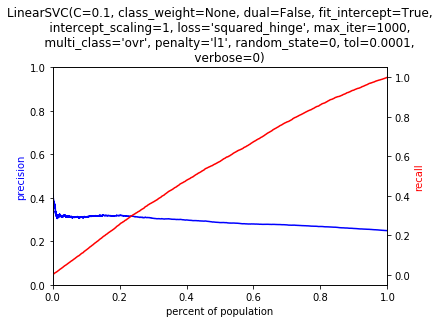

<Figure size 432x288 with 0 Axes>

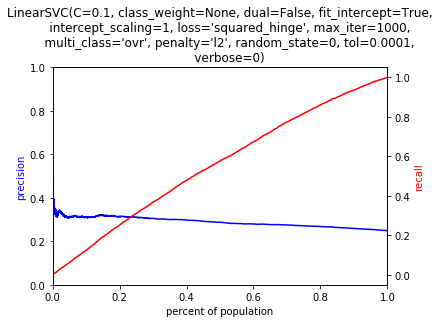

<Figure size 432x288 with 0 Axes>

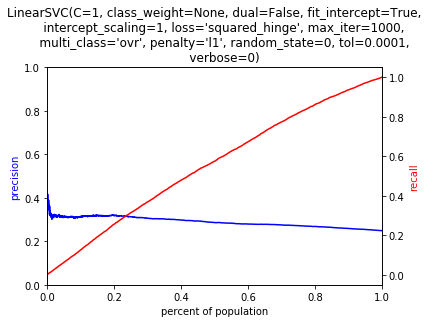

<Figure size 432x288 with 0 Axes>

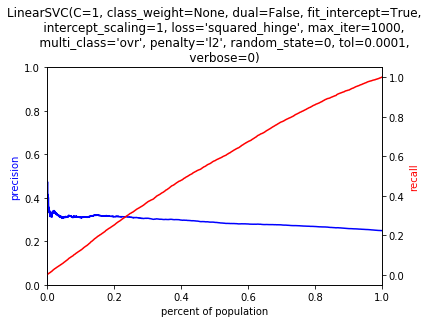

KNN


<Figure size 432x288 with 0 Axes>

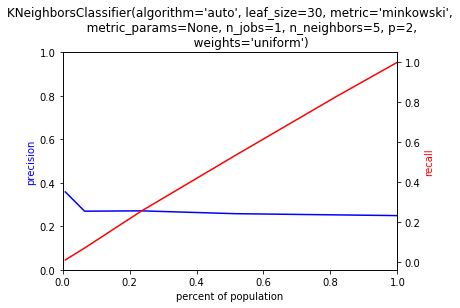

<Figure size 432x288 with 0 Axes>

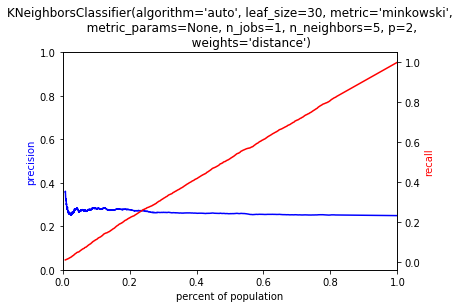

<Figure size 432x288 with 0 Axes>

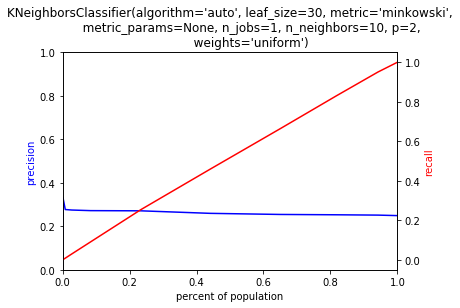

<Figure size 432x288 with 0 Axes>

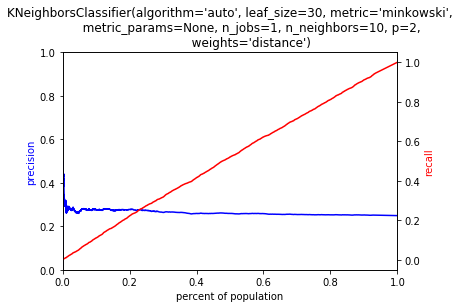

LR


<Figure size 432x288 with 0 Axes>

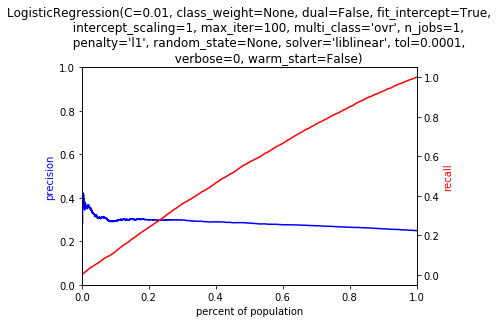

<Figure size 432x288 with 0 Axes>

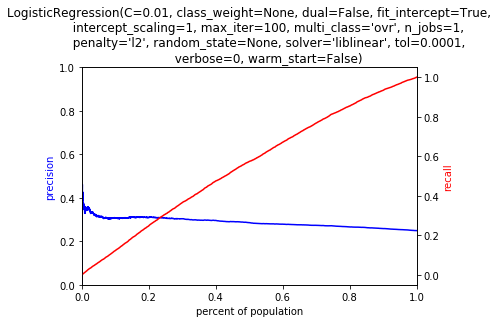

<Figure size 432x288 with 0 Axes>

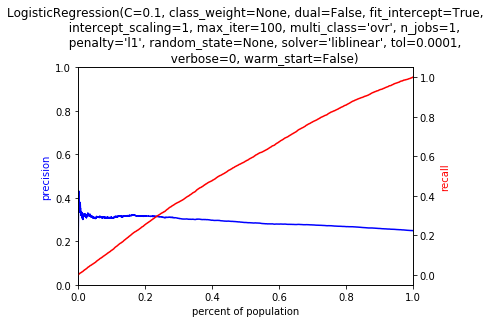

<Figure size 432x288 with 0 Axes>

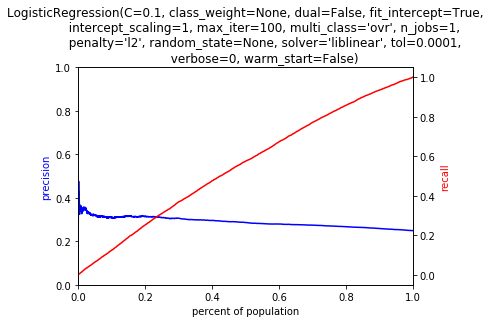

<Figure size 432x288 with 0 Axes>

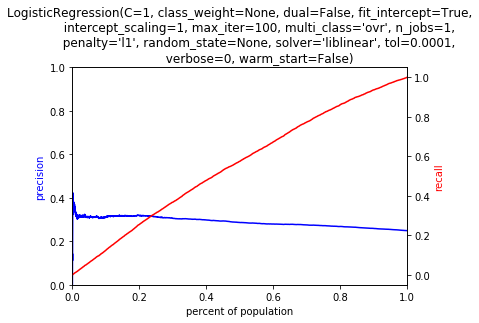

<Figure size 432x288 with 0 Axes>

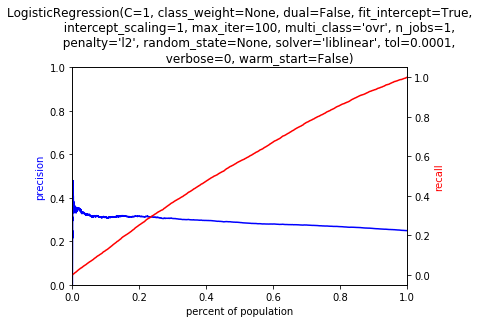

<Figure size 432x288 with 0 Axes>

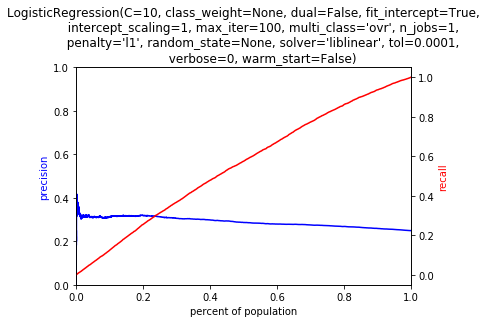

<Figure size 432x288 with 0 Axes>

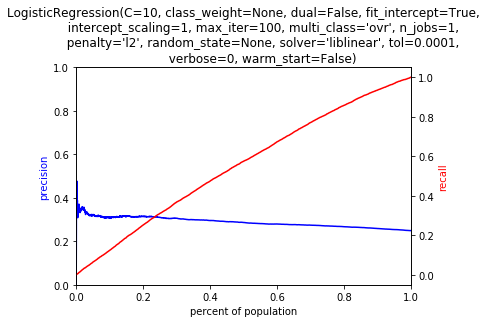

BG


<Figure size 432x288 with 0 Axes>

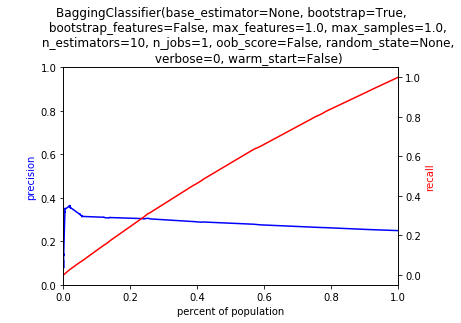

<Figure size 432x288 with 0 Axes>

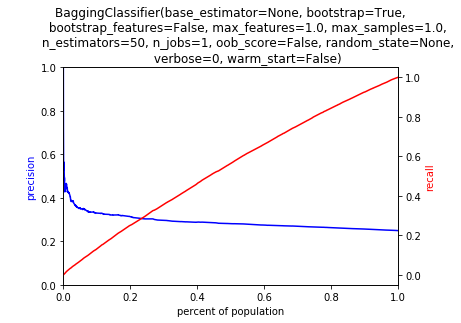

train_test_data_period_2
RF


<Figure size 432x288 with 0 Axes>

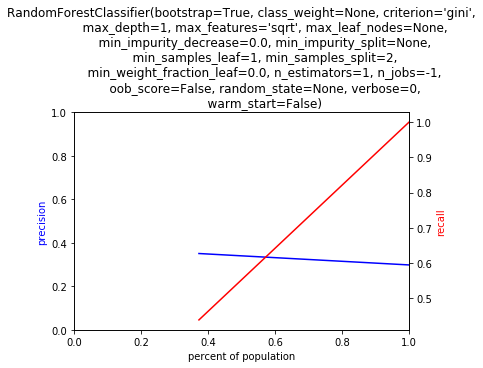

<Figure size 432x288 with 0 Axes>

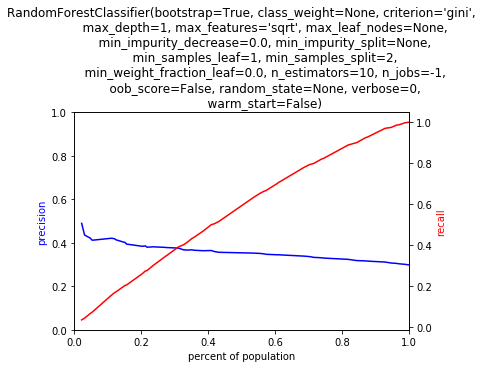

<Figure size 432x288 with 0 Axes>

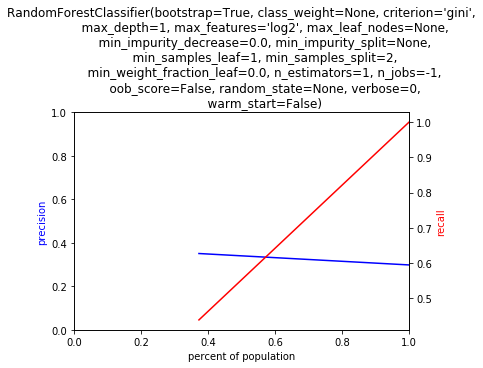

<Figure size 432x288 with 0 Axes>

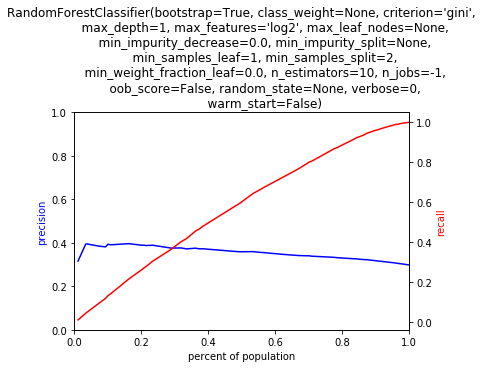

<Figure size 432x288 with 0 Axes>

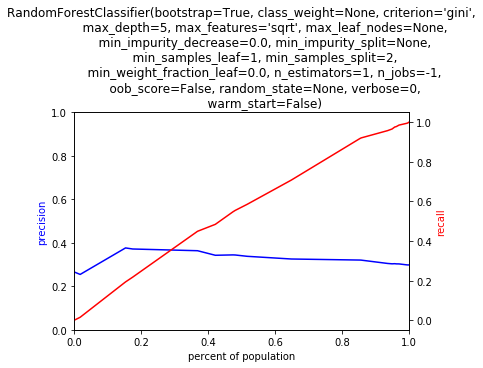

<Figure size 432x288 with 0 Axes>

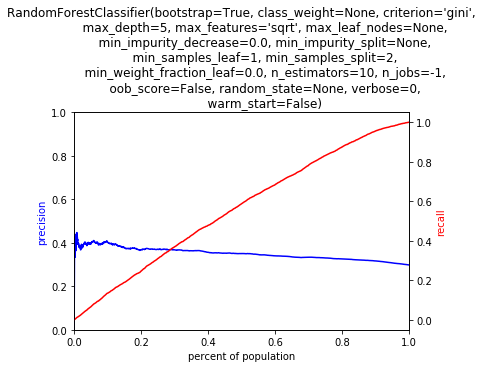

<Figure size 432x288 with 0 Axes>

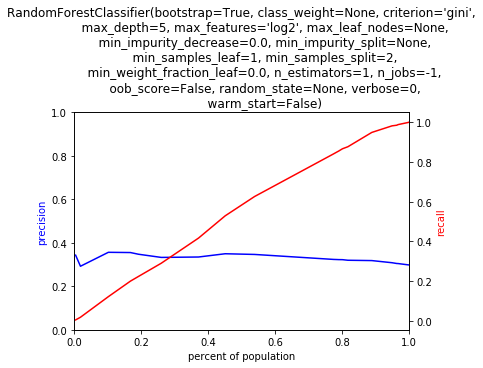

<Figure size 432x288 with 0 Axes>

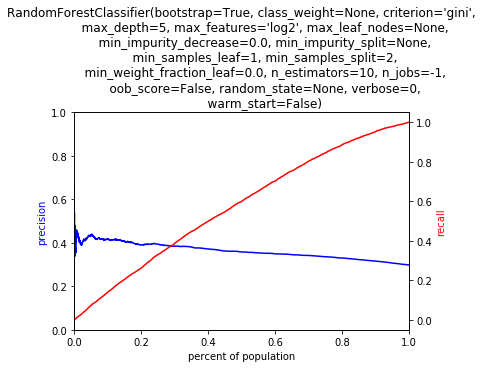

<Figure size 432x288 with 0 Axes>

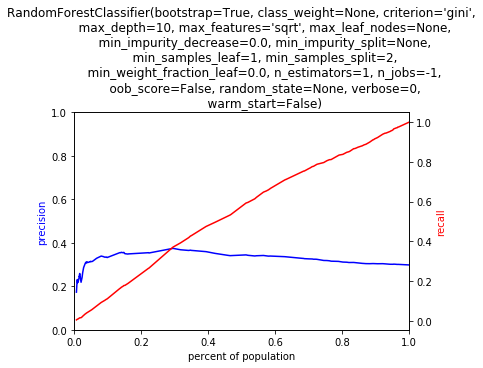

<Figure size 432x288 with 0 Axes>

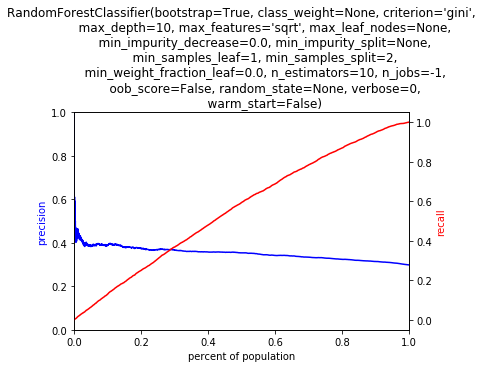

<Figure size 432x288 with 0 Axes>

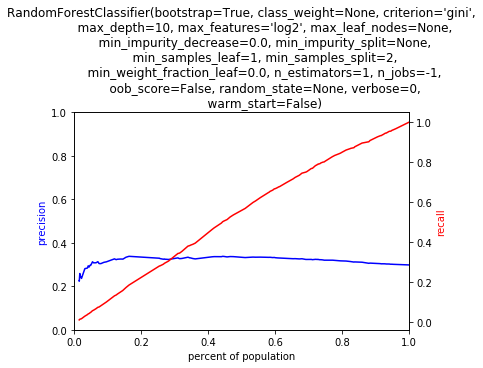

<Figure size 432x288 with 0 Axes>

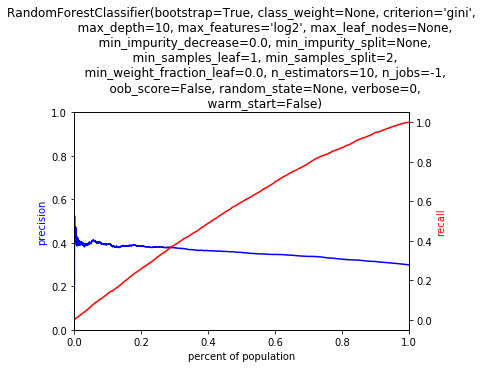

DT


/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

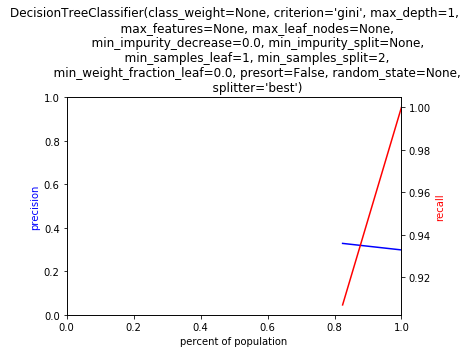

<Figure size 432x288 with 0 Axes>

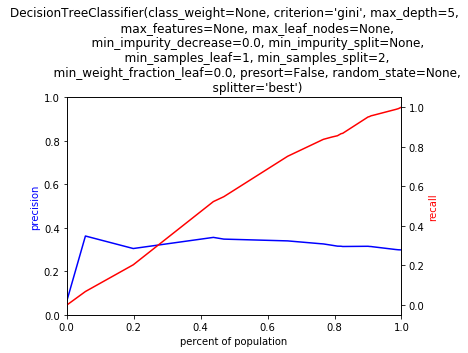

/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

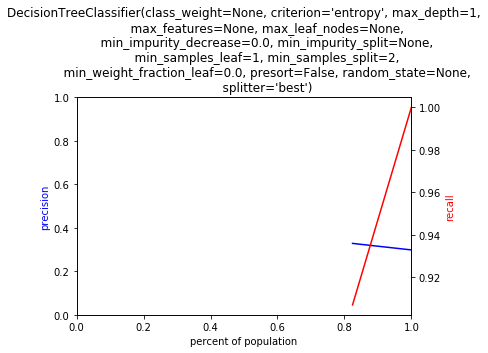

<Figure size 432x288 with 0 Axes>

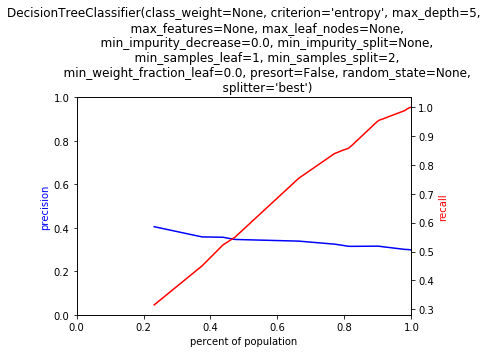

GB


<Figure size 432x288 with 0 Axes>

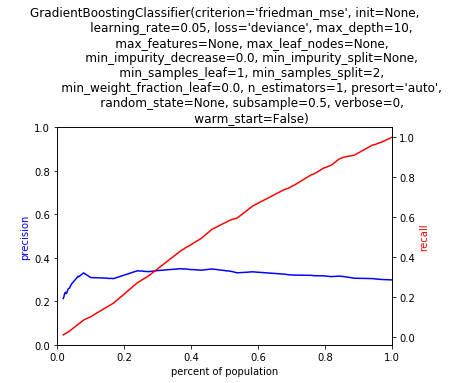

<Figure size 432x288 with 0 Axes>

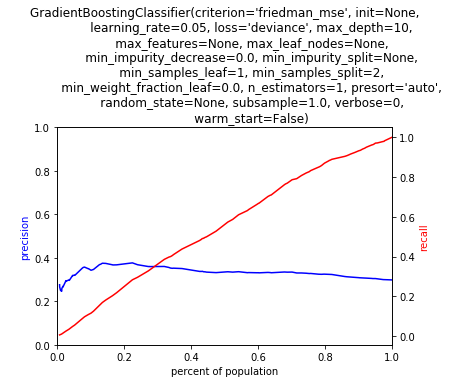

<Figure size 432x288 with 0 Axes>

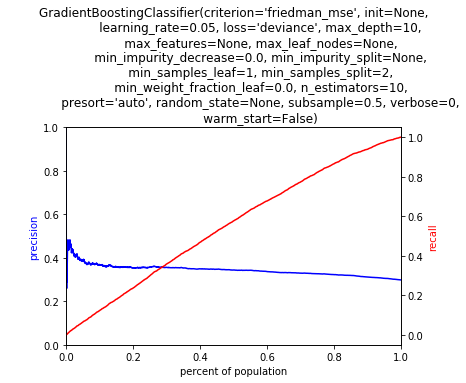

<Figure size 432x288 with 0 Axes>

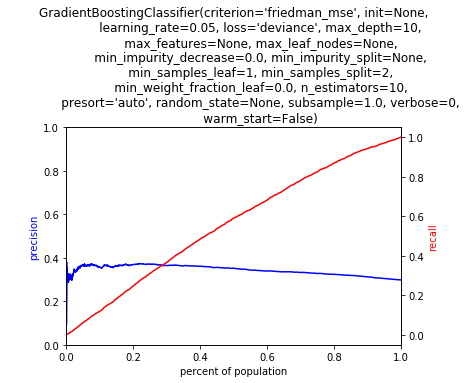

<Figure size 432x288 with 0 Axes>

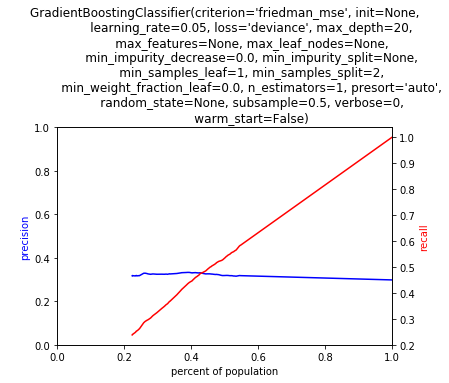

<Figure size 432x288 with 0 Axes>

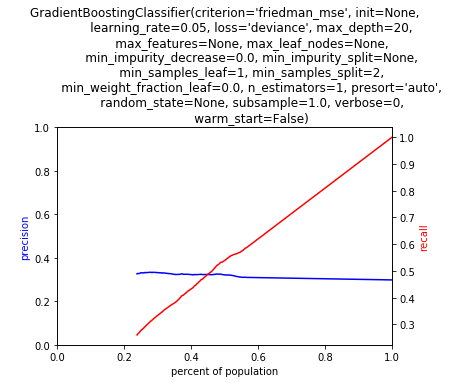

<Figure size 432x288 with 0 Axes>

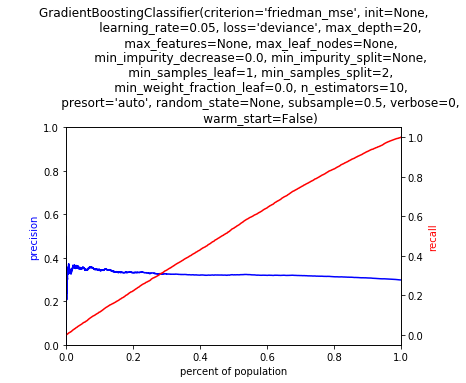

<Figure size 432x288 with 0 Axes>

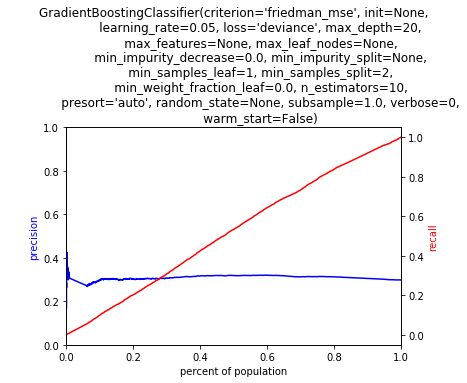

<Figure size 432x288 with 0 Axes>

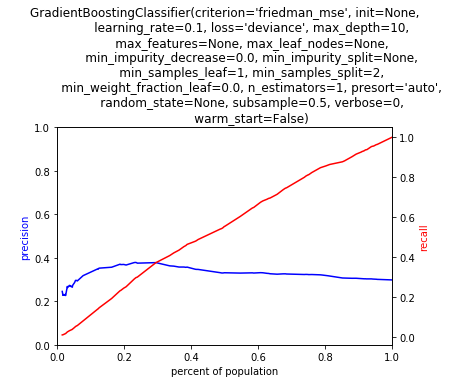

<Figure size 432x288 with 0 Axes>

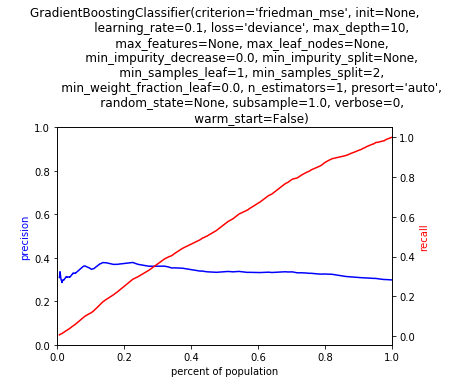

<Figure size 432x288 with 0 Axes>

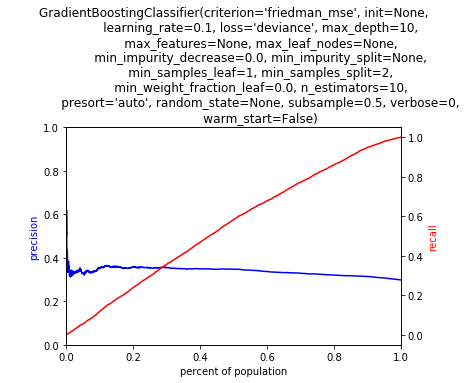

<Figure size 432x288 with 0 Axes>

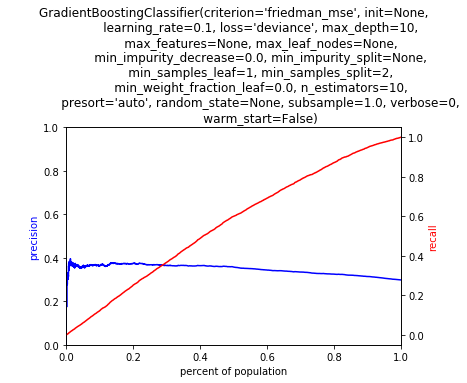

<Figure size 432x288 with 0 Axes>

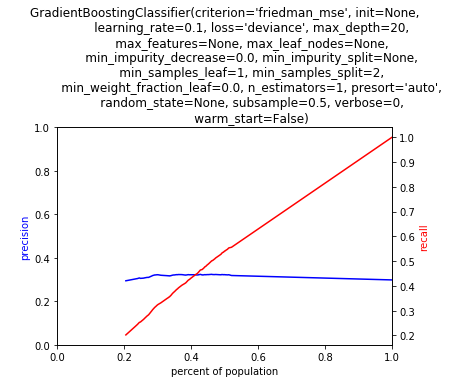

<Figure size 432x288 with 0 Axes>

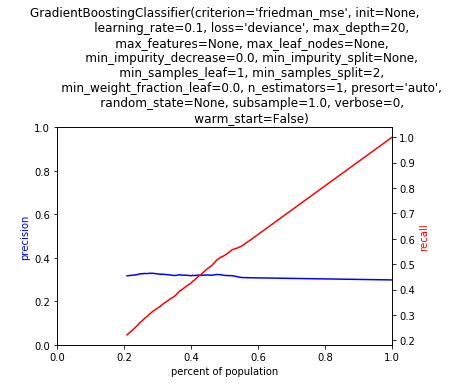

<Figure size 432x288 with 0 Axes>

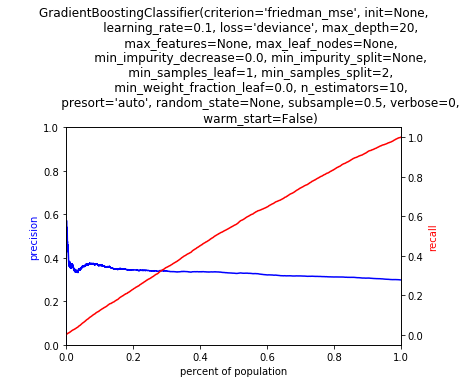

<Figure size 432x288 with 0 Axes>

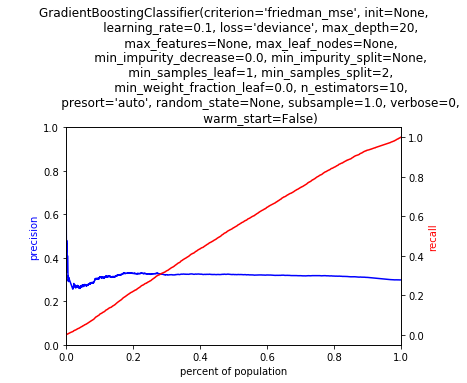

SVM


<Figure size 432x288 with 0 Axes>

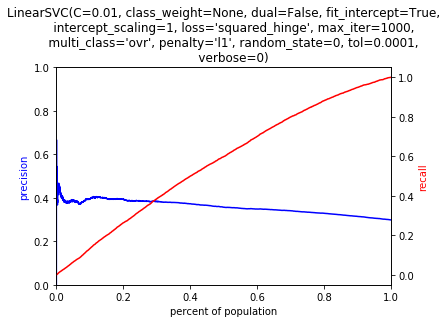

<Figure size 432x288 with 0 Axes>

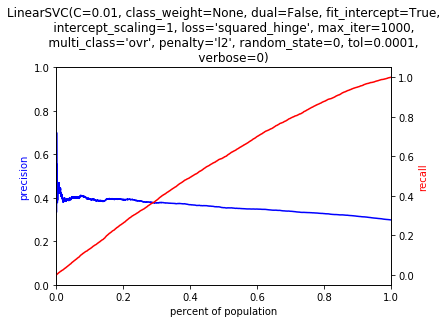

<Figure size 432x288 with 0 Axes>

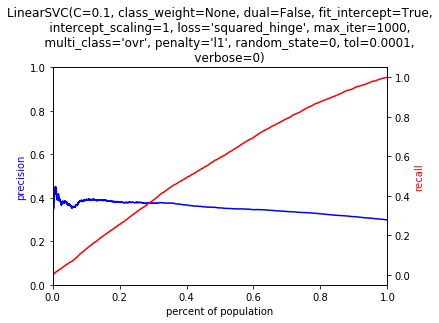

<Figure size 432x288 with 0 Axes>

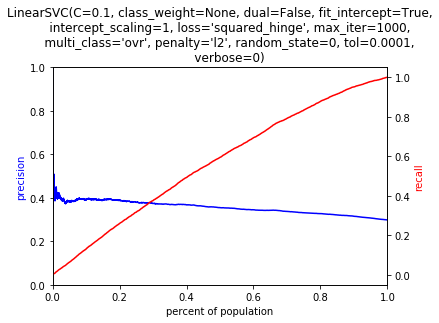

<Figure size 432x288 with 0 Axes>

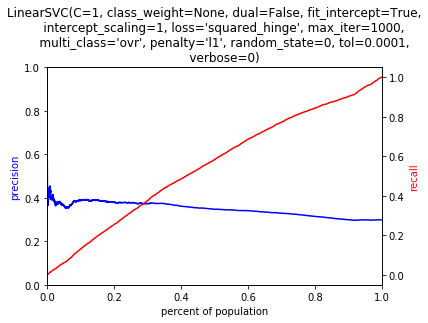

<Figure size 432x288 with 0 Axes>

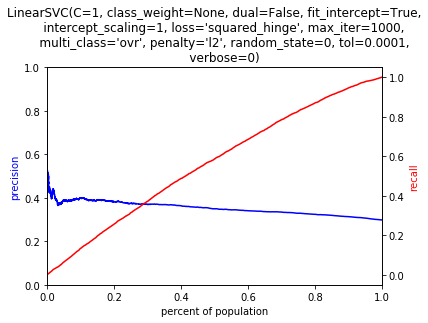

KNN


<Figure size 432x288 with 0 Axes>

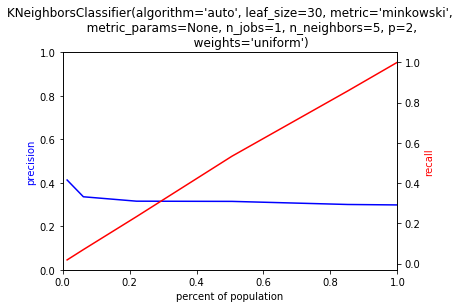

<Figure size 432x288 with 0 Axes>

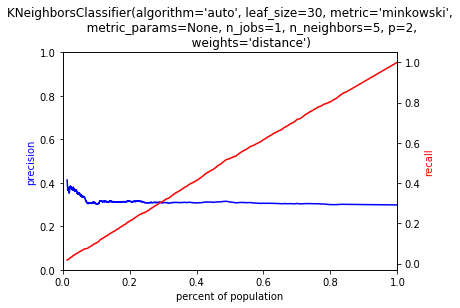

<Figure size 432x288 with 0 Axes>

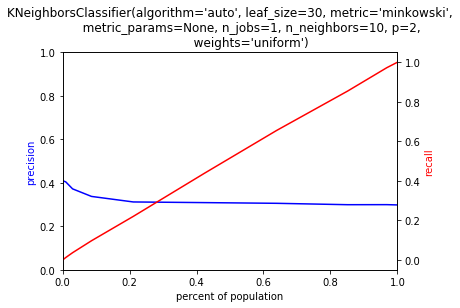

<Figure size 432x288 with 0 Axes>

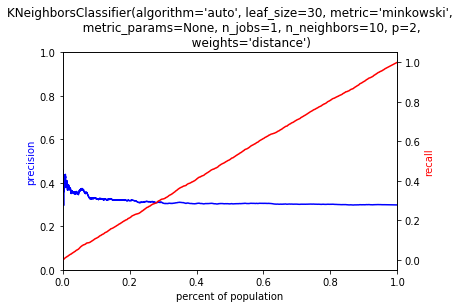

LR


<Figure size 432x288 with 0 Axes>

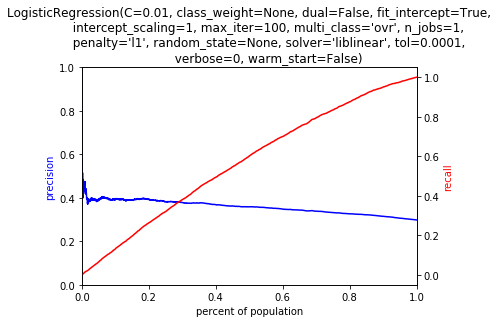

<Figure size 432x288 with 0 Axes>

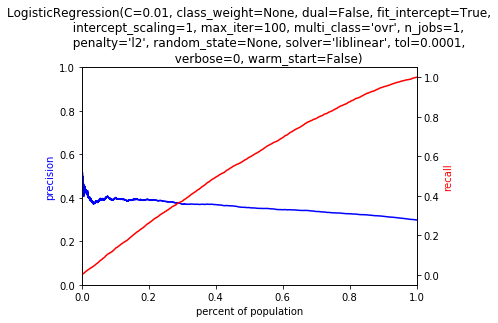

<Figure size 432x288 with 0 Axes>

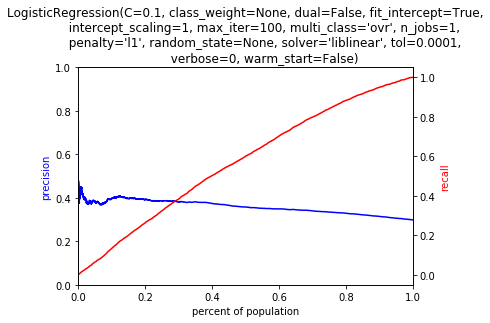

<Figure size 432x288 with 0 Axes>

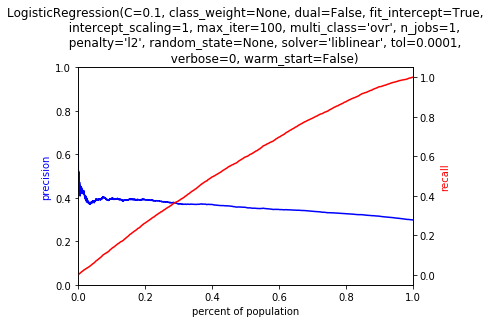

<Figure size 432x288 with 0 Axes>

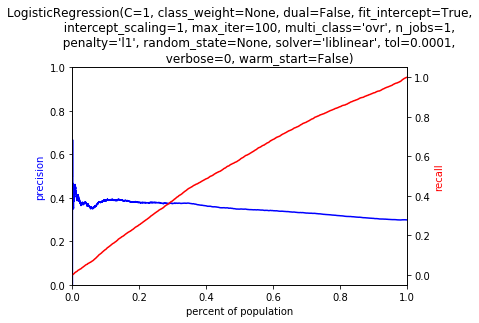

<Figure size 432x288 with 0 Axes>

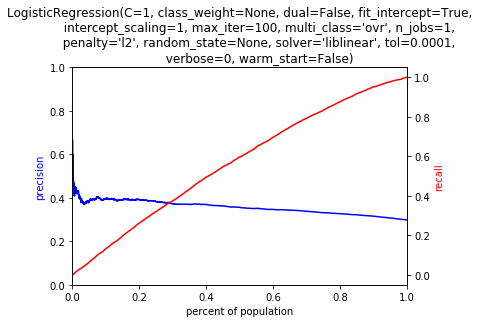

<Figure size 432x288 with 0 Axes>

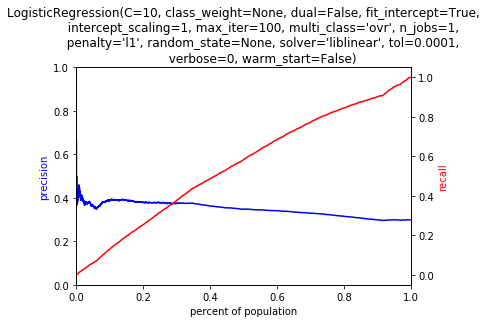

<Figure size 432x288 with 0 Axes>

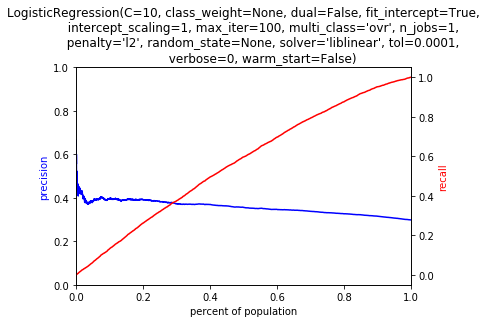

BG


<Figure size 432x288 with 0 Axes>

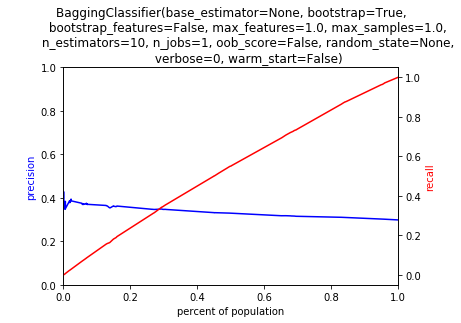

<Figure size 432x288 with 0 Axes>

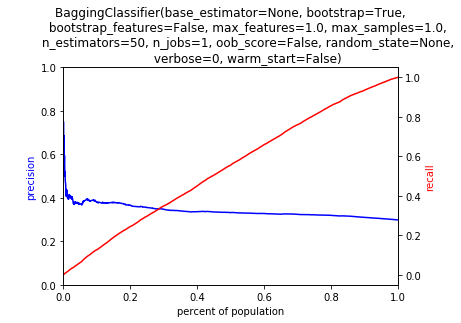

train_test_data_period_3
RF


/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

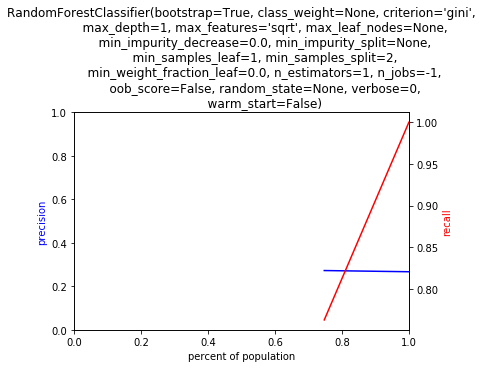

<Figure size 432x288 with 0 Axes>

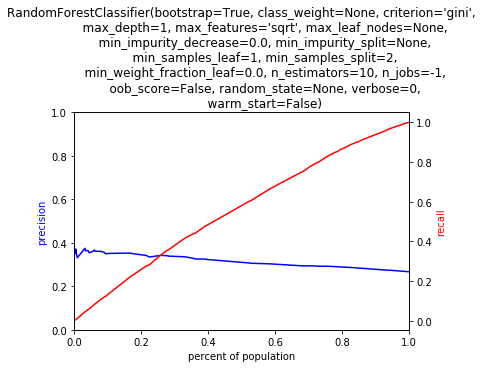

/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

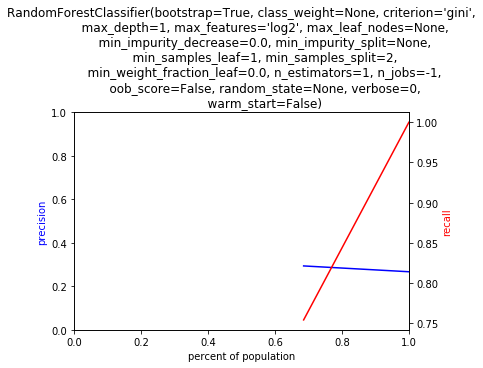

<Figure size 432x288 with 0 Axes>

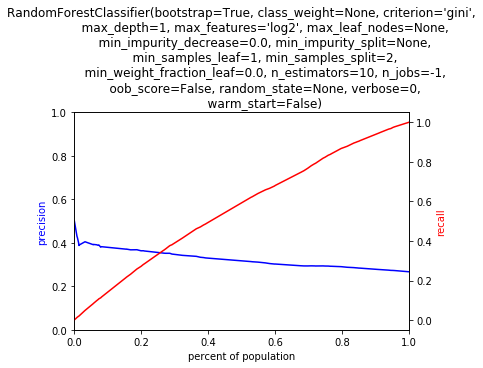

<Figure size 432x288 with 0 Axes>

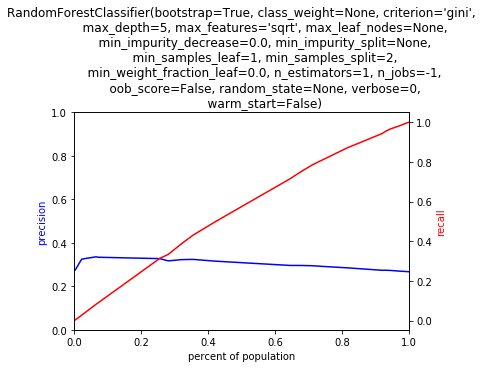

<Figure size 432x288 with 0 Axes>

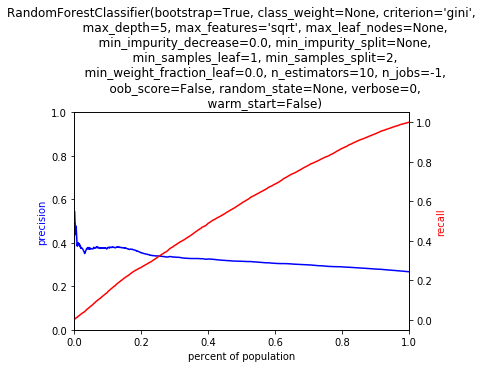

<Figure size 432x288 with 0 Axes>

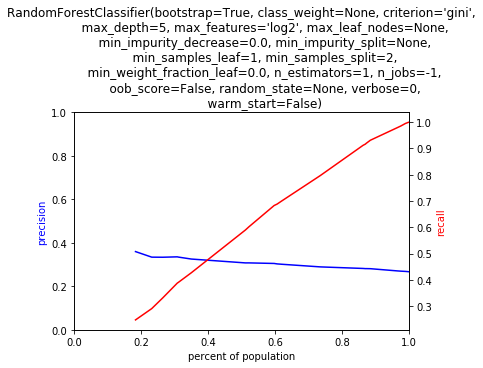

<Figure size 432x288 with 0 Axes>

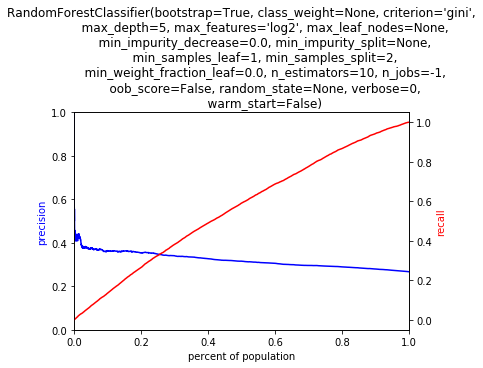

<Figure size 432x288 with 0 Axes>

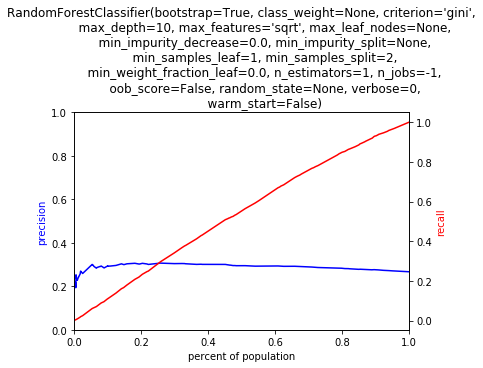

<Figure size 432x288 with 0 Axes>

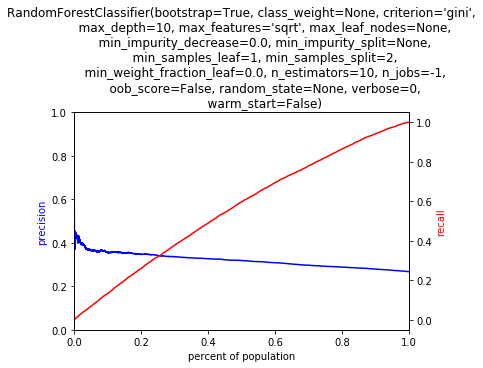

<Figure size 432x288 with 0 Axes>

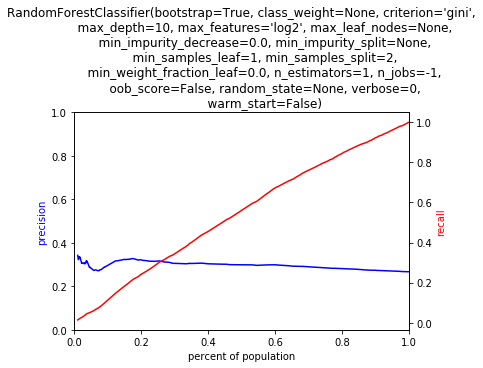

<Figure size 432x288 with 0 Axes>

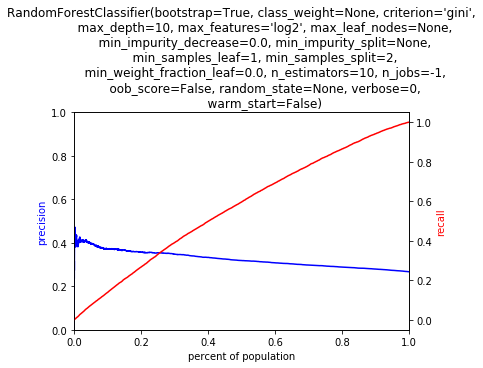

DT


/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

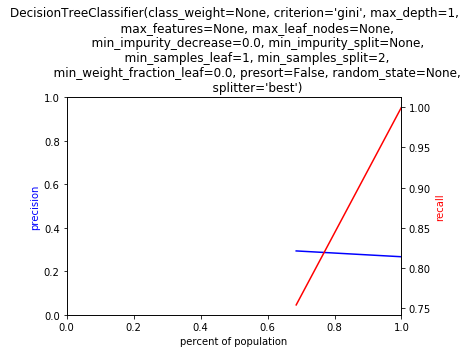

<Figure size 432x288 with 0 Axes>

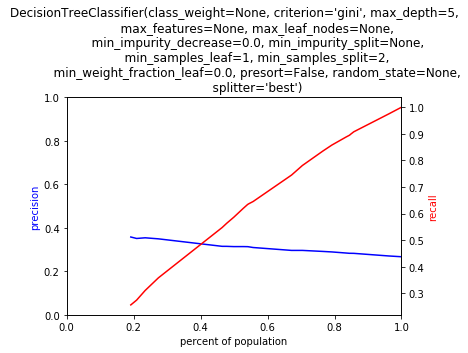

/Users/norahajjar/github/machine_learning/HW Assignments/HW5/final_pipeline.py:322: RuntimeWarning: invalid value encountered in double_scalars
  return 2 * (precision * recall)/(precision + recall)


<Figure size 432x288 with 0 Axes>

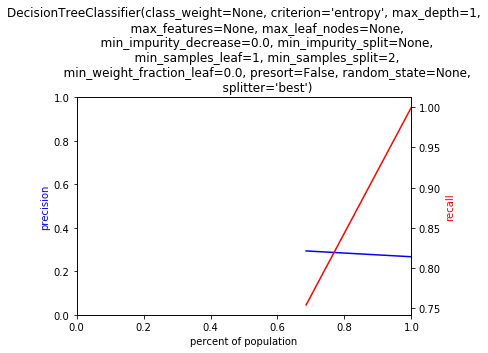

<Figure size 432x288 with 0 Axes>

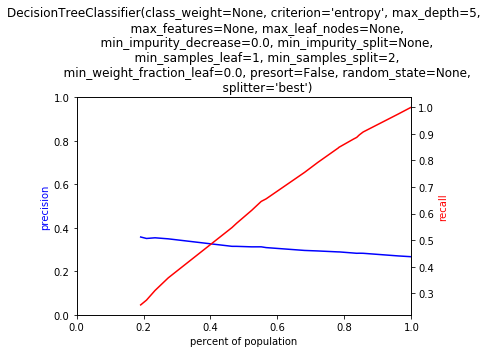

GB


<Figure size 432x288 with 0 Axes>

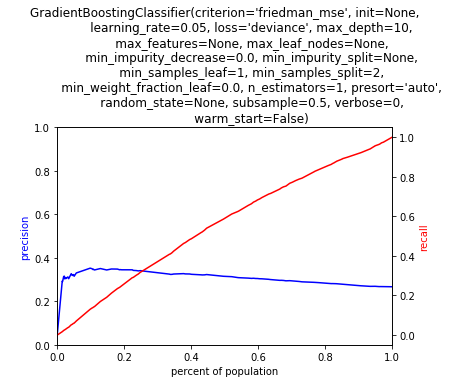

<Figure size 432x288 with 0 Axes>

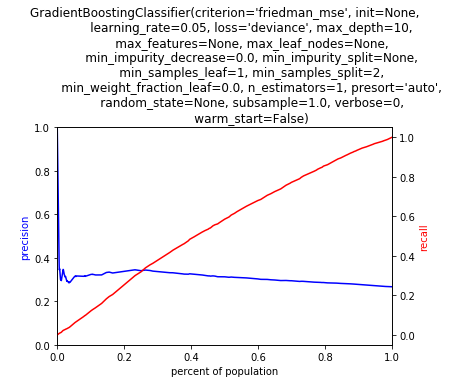

<Figure size 432x288 with 0 Axes>

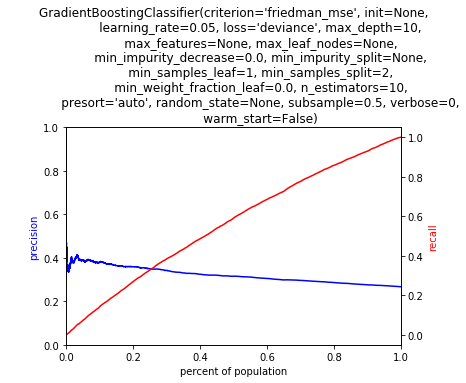

<Figure size 432x288 with 0 Axes>

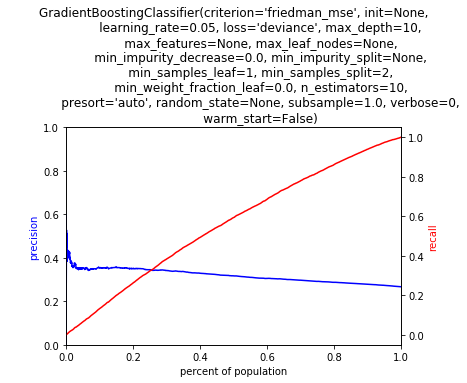

<Figure size 432x288 with 0 Axes>

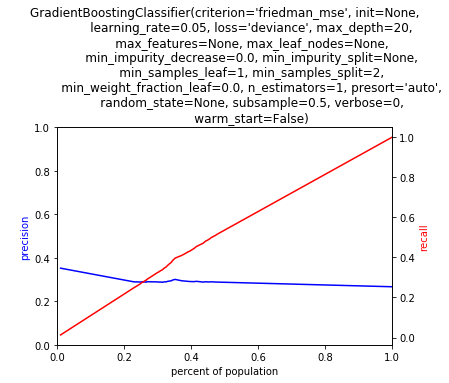

<Figure size 432x288 with 0 Axes>

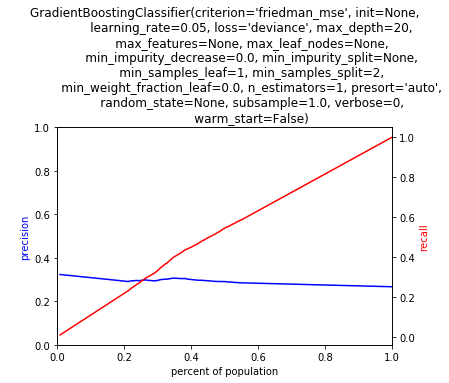

<Figure size 432x288 with 0 Axes>

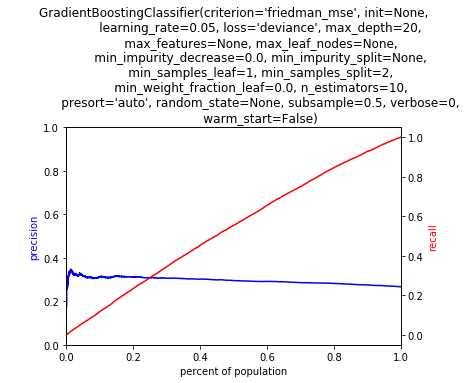

<Figure size 432x288 with 0 Axes>

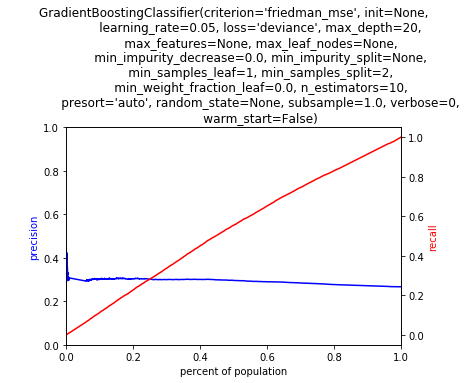

<Figure size 432x288 with 0 Axes>

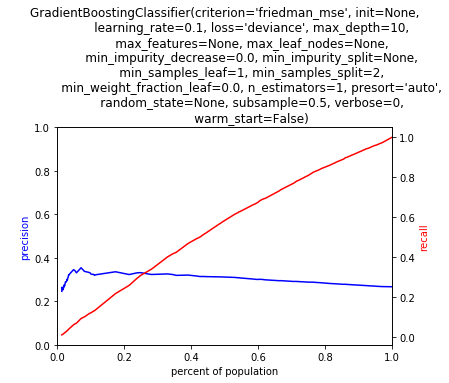

<Figure size 432x288 with 0 Axes>

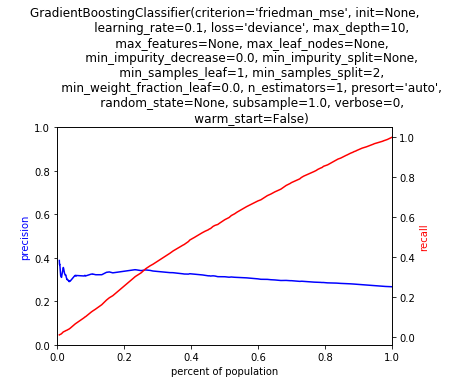

<Figure size 432x288 with 0 Axes>

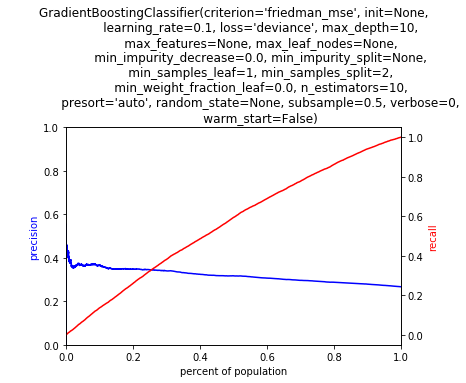

<Figure size 432x288 with 0 Axes>

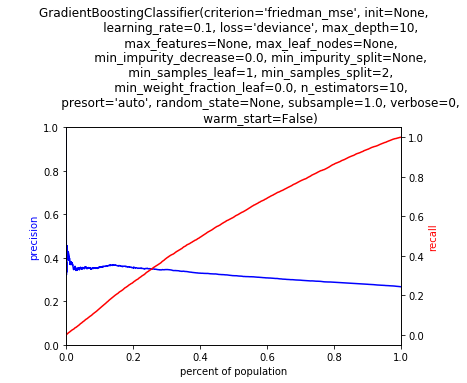

<Figure size 432x288 with 0 Axes>

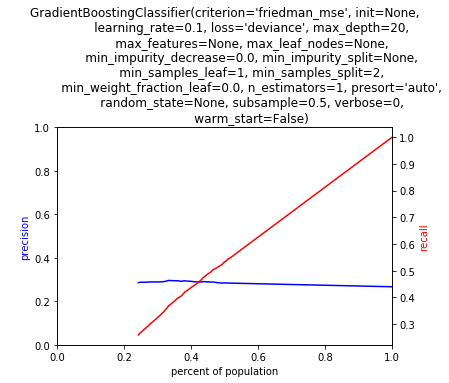

<Figure size 432x288 with 0 Axes>

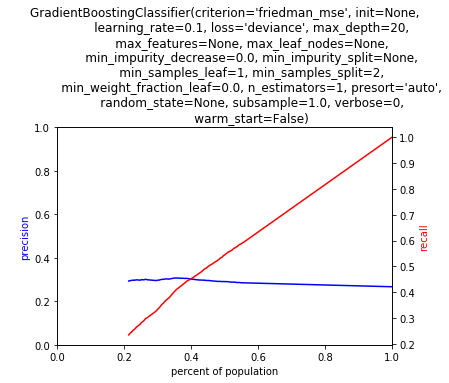

<Figure size 432x288 with 0 Axes>

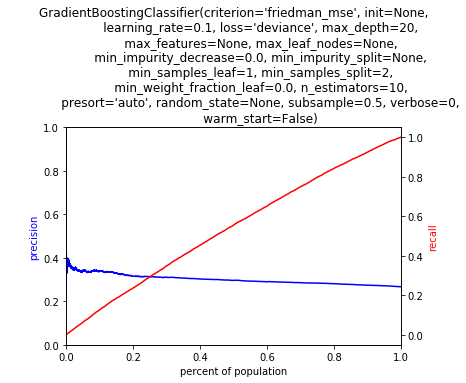

<Figure size 432x288 with 0 Axes>

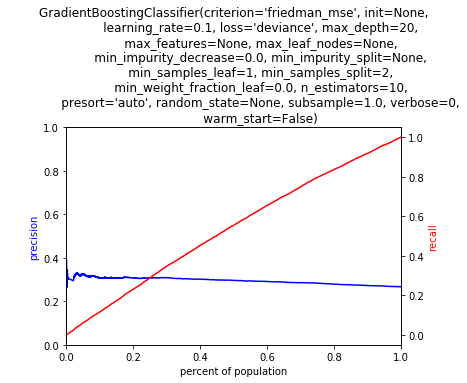

SVM


<Figure size 432x288 with 0 Axes>

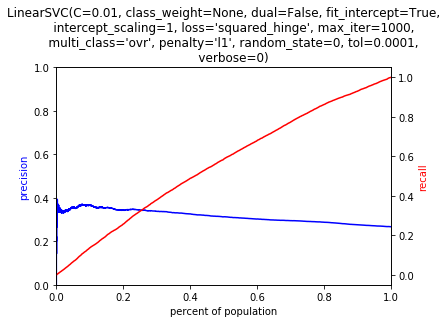

<Figure size 432x288 with 0 Axes>

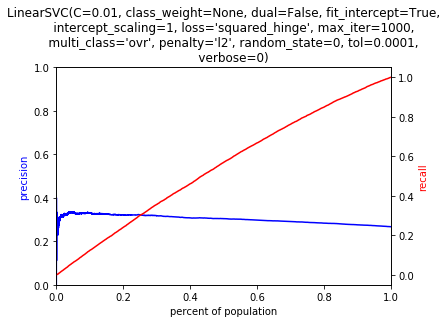

<Figure size 432x288 with 0 Axes>

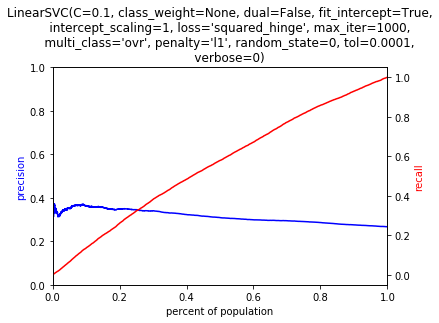

<Figure size 432x288 with 0 Axes>

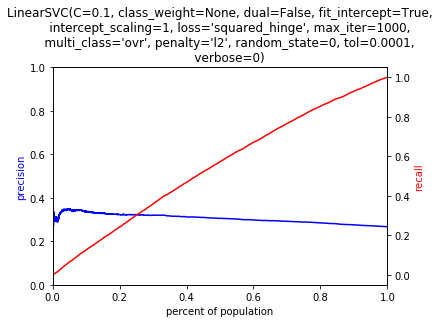

<Figure size 432x288 with 0 Axes>

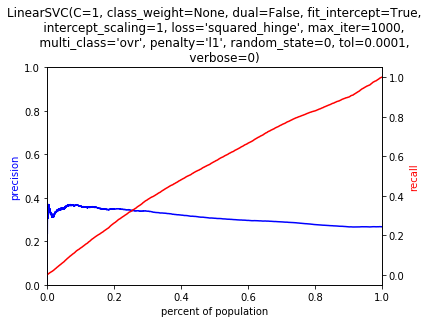

<Figure size 432x288 with 0 Axes>

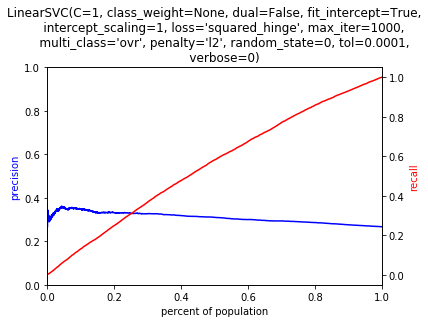

KNN


<Figure size 432x288 with 0 Axes>

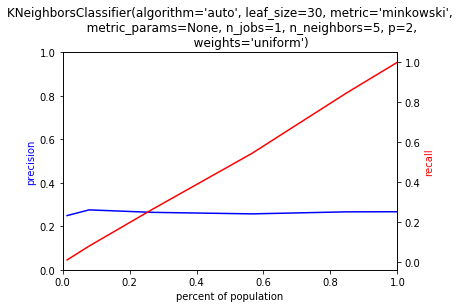

<Figure size 432x288 with 0 Axes>

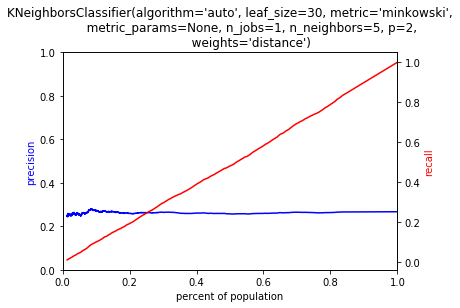

<Figure size 432x288 with 0 Axes>

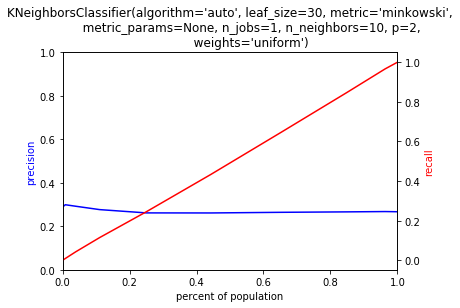

<Figure size 432x288 with 0 Axes>

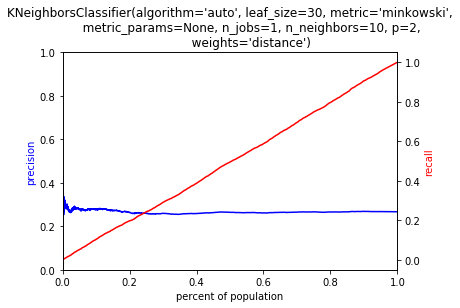

LR


<Figure size 432x288 with 0 Axes>

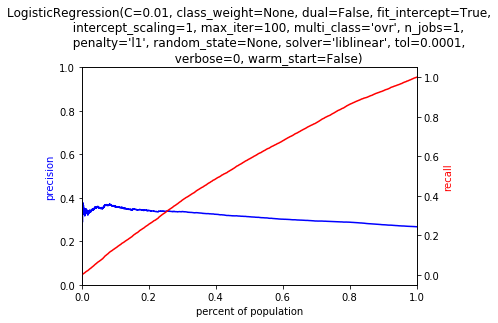

<Figure size 432x288 with 0 Axes>

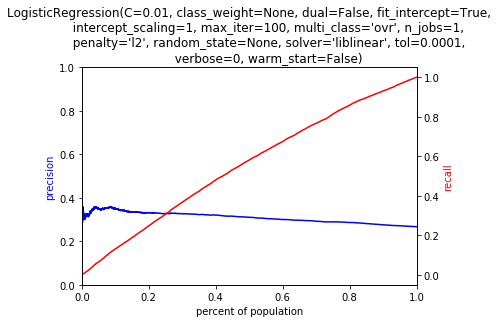

<Figure size 432x288 with 0 Axes>

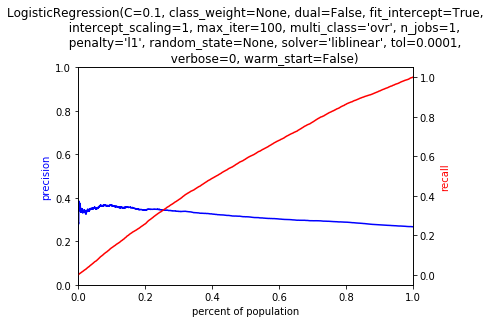

<Figure size 432x288 with 0 Axes>

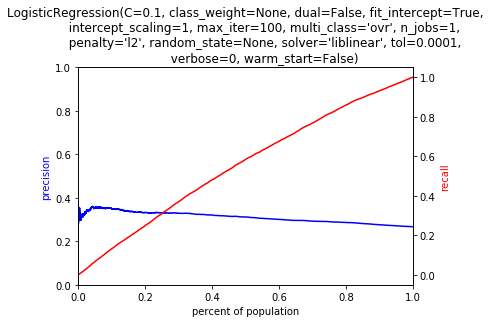

<Figure size 432x288 with 0 Axes>

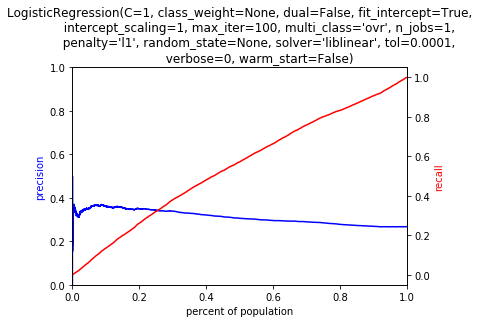

<Figure size 432x288 with 0 Axes>

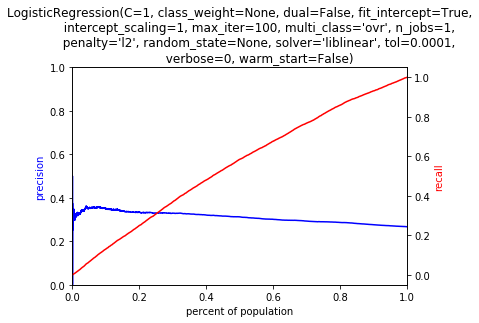

<Figure size 432x288 with 0 Axes>

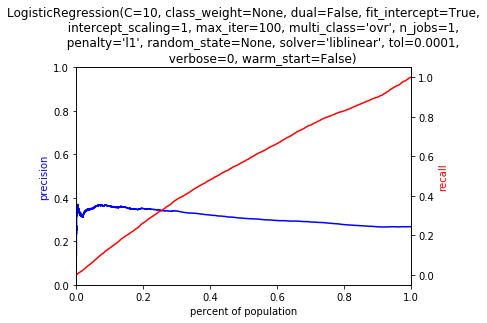

<Figure size 432x288 with 0 Axes>

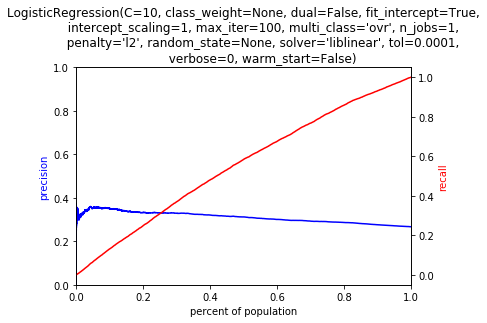

BG


<Figure size 432x288 with 0 Axes>

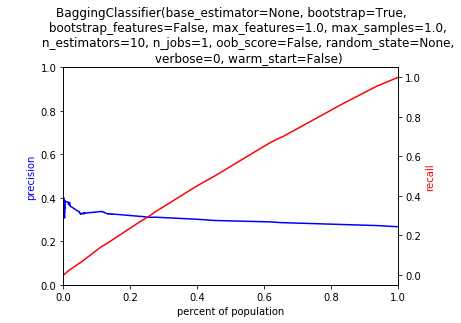

<Figure size 432x288 with 0 Axes>

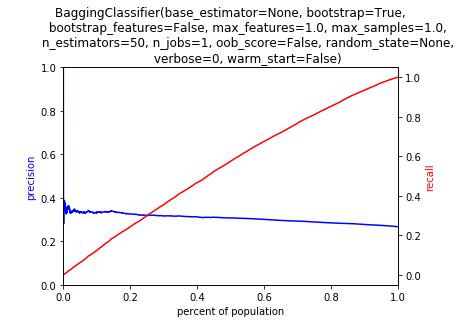

In [63]:
#run full magic loop function on all data 
#save to a final df for analysis/review
results_df = p.clf_loop_all_data(models_to_run, clfs, grid, train_test_dfs, pred_vars, dep_var)

In [64]:
results_df

time_period model_type  \
0    train_test_data_period_1         RF   
1    train_test_data_period_1         RF   
2    train_test_data_period_1         RF   
3    train_test_data_period_1         RF   
4    train_test_data_period_1         RF   
5    train_test_data_period_1         RF   
6    train_test_data_period_1         RF   
7    train_test_data_period_1         RF   
8    train_test_data_period_1         RF   
9    train_test_data_period_1         RF   
10   train_test_data_period_1         RF   
11   train_test_data_period_1         RF   
12   train_test_data_period_1         DT   
13   train_test_data_period_1         DT   
14   train_test_data_period_1         DT   
15   train_test_data_period_1         DT   
16   train_test_data_period_1         GB   
17   train_test_data_period_1         GB   
18   train_test_data_period_1         GB   
19   train_test_data_period_1         GB   
20   train_test_data_period_1         GB   
21   train_test_data_period_1         GB   
22   train_test_data_period_1         GB   
23   train_test_data_period_1         GB   
24   train_test_data_period_1         GB   
25   train_test_data_period_1         GB   
26   train_test_data_period_1         GB   
27   train_test_data_period_1         GB   
28   train_test_data_period_1         GB   
29   train_test_data_period_1         GB   
..                        ...        ...   
126  train_test_data_period_3         GB   
127  train_test_data_period_3         GB   
128  train_test_data_period_3         GB   
129  train_test_data_period_3         GB   
130  train_test_data_period_3         GB   
131  train_test_data_period_3         GB   
132  train_test_data_period_3         GB   
133  train_test_data_period_3         GB   
134  train_test_data_period_3         GB   
135  train_test_data_period_3         GB   
136  train_test_data_period_3        SVM   
137  train_test_data_period_3        SVM   
138  train_test_data_period_3        SVM   
139  train_test_data_period_3        SVM   
140  train_test_data_period_3        SVM   
141  train_test_data_period_3        SVM   
142  train_test_data_period_3        KNN   
143  train_test_data_period_3        KNN   
144  train_test_data_period_3        KNN   
145  train_test_data_period_3        KNN   
146  train_test_data_period_3         LR   
147  train_test_data_period_3         LR   
148  train_test_data_period_3         LR   
149  train_test_data_period_3         LR   
150  train_test_data_period_3         LR   
151  train_test_data_period_3         LR   
152  train_test_data_period_3         LR   
153  train_test_data_period_3         LR   
154  train_test_data_period_3         BG   
155  train_test_data_period_3         BG   

                                                   clf  \
0    (DecisionTreeClassifier(class_weight=None, cri...   
1    (DecisionTreeClassifier(class_weight=None, cri...   
2    (DecisionTreeClassifier(class_weight=None, cri...   
3    (DecisionTreeClassifier(class_weight=None, cri...   
4    (DecisionTreeClassifier(class_weight=None, cri...   
5    (DecisionTreeClassifier(class_weight=None, cri...   
6    (DecisionTreeClassifier(class_weight=None, cri...   
7    (DecisionTreeClassifier(class_weight=None, cri...   
8    (DecisionTreeClassifier(class_weight=None, cri...   
9    (DecisionTreeClassifier(class_weight=None, cri...   
10   (DecisionTreeClassifier(class_weight=None, cri...   
11   (DecisionTreeClassifier(class_weight=None, cri...   
12   DecisionTreeClassifier(class_weight=None, crit...   
13   DecisionTreeClassifier(class_weight=None, crit...   
14   DecisionTreeClassifier(class_weight=None, crit...   
15   DecisionTreeClassifier(class_weight=None, crit...   
16   ([DecisionTreeRegressor(criterion='friedman_ms...   
17   ([DecisionTreeRegressor(criterion='friedman_ms...   
18   ([DecisionTreeRegressor(criterion='friedman_ms...   
19   ([DecisionTreeRegressor(criterion='friedman_ms...   
20   ([DecisionTreeRegressor(criterion='friedman_ms...   
21   ([Decisi

In [65]:
#output results to CSV
results_df.to_csv('data_output.csv')

In [72]:
#filter to just the 5% population target, as noted in the write-up. 
filtered_df = results_df[['time_period', 'model_type', 'clf', 'parameters', 'auc-roc', 'p_at_5', 'r_at_5', 'f1_at_5']].copy()



In [73]:
filtered_df

time_period model_type  \
0    train_test_data_period_1         RF   
1    train_test_data_period_1         RF   
2    train_test_data_period_1         RF   
3    train_test_data_period_1         RF   
4    train_test_data_period_1         RF   
5    train_test_data_period_1         RF   
6    train_test_data_period_1         RF   
7    train_test_data_period_1         RF   
8    train_test_data_period_1         RF   
9    train_test_data_period_1         RF   
10   train_test_data_period_1         RF   
11   train_test_data_period_1         RF   
12   train_test_data_period_1         DT   
13   train_test_data_period_1         DT   
14   train_test_data_period_1         DT   
15   train_test_data_period_1         DT   
16   train_test_data_period_1         GB   
17   train_test_data_period_1         GB   
18   train_test_data_period_1         GB   
19   train_test_data_period_1         GB   
20   train_test_data_period_1         GB   
21   train_test_data_period_1         GB   
22   train_test_data_period_1         GB   
23   train_test_data_period_1         GB   
24   train_test_data_period_1         GB   
25   train_test_data_period_1         GB   
26   train_test_data_period_1         GB   
27   train_test_data_period_1         GB   
28   train_test_data_period_1         GB   
29   train_test_data_period_1         GB   
..                        ...        ...   
126  train_test_data_period_3         GB   
127  train_test_data_period_3         GB   
128  train_test_data_period_3         GB   
129  train_test_data_period_3         GB   
130  train_test_data_period_3         GB   
131  train_test_data_period_3         GB   
132  train_test_data_period_3         GB   
133  train_test_data_period_3         GB   
134  train_test_data_period_3         GB   
135  train_test_data_period_3         GB   
136  train_test_data_period_3        SVM   
137  train_test_data_period_3        SVM   
138  train_test_data_period_3        SVM   
139  train_test_data_period_3        SVM   
140  train_test_data_period_3        SVM   
141  train_test_data_period_3        SVM   
142  train_test_data_period_3        KNN   
143  train_test_data_period_3        KNN   
144  train_test_data_period_3        KNN   
145  train_test_data_period_3        KNN   
146  train_test_data_period_3         LR   
147  train_test_data_period_3         LR   
148  train_test_data_period_3         LR   
149  train_test_data_period_3         LR   
150  train_test_data_period_3         LR   
151  train_test_data_period_3         LR   
152  train_test_data_period_3         LR   
153  train_test_data_period_3         LR   
154  train_test_data_period_3         BG   
155  train_test_data_period_3         BG   

                                                   clf  \
0    (DecisionTreeClassifier(class_weight=None, cri...   
1    (DecisionTreeClassifier(class_weight=None, cri...   
2    (DecisionTreeClassifier(class_weight=None, cri...   
3    (DecisionTreeClassifier(class_weight=None, cri...   
4    (DecisionTreeClassifier(class_weight=None, cri...   
5    (DecisionTreeClassifier(class_weight=None, cri...   
6    (DecisionTreeClassifier(class_weight=None, cri...   
7    (DecisionTreeClassifier(class_weight=None, cri...   
8    (DecisionTreeClassifier(class_weight=None, cri...   
9    (DecisionTreeClassifier(class_weight=None, cri...   
10   (DecisionTreeClassifier(class_weight=None, cri...   
11   (DecisionTreeClassifier(class_weight=None, cri...   
12   DecisionTreeClassifier(class_weight=None, crit...   
13   DecisionTreeClassifier(class_weight=None, crit...   
14   DecisionTreeClassifier(class_weight=None, crit...   
15   DecisionTreeClassifier(class_weight=None, crit...   
16   ([DecisionTreeRegressor(criterion='friedman_ms...   
17   ([DecisionTreeRegressor(criterion='friedman_ms...   
18   ([DecisionTreeRegressor(criterion='friedman_ms...   
19   ([DecisionTreeRegressor(criterion='friedman_ms...   
20   ([DecisionTreeRegressor(criterion='friedman_ms...   
21   ([Decisi

In [75]:
#filter by F1, a useful score for determining performance
filtered_df.sort_values(by=['f1_at_5', 'time_period'], ascending=False)

time_period model_type  \
59   train_test_data_period_2         RF   
115  train_test_data_period_3         RF   
122  train_test_data_period_3         GB   
111  train_test_data_period_3         RF   
51   train_test_data_period_1         BG   
53   train_test_data_period_2         RF   
7    train_test_data_period_1         RF   
109  train_test_data_period_3         RF   
113  train_test_data_period_3         RF   
85   train_test_data_period_2        SVM   
130  train_test_data_period_3         GB   
63   train_test_data_period_2         RF   
107  train_test_data_period_3         RF   
57   train_test_data_period_2         RF   
146  train_test_data_period_3         LR   
9    train_test_data_period_1         RF   
94   train_test_data_period_2         LR   
136  train_test_data_period_3        SVM   
141  train_test_data_period_3        SVM   
148  train_test_data_period_3         LR   
149  train_test_data_period_3         LR   
151  train_test_data_period_3         LR   
153  train_test_data_period_3         LR   
131  train_test_data_period_3         GB   
138  train_test_data_period_3        SVM   
84   train_test_data_period_2        SVM   
89   train_test_data_period_2        SVM   
147  train_test_data_period_3         LR   
152  train_test_data_period_3         LR   
70   train_test_data_period_2         GB   
..                        ...        ...   
56   train_test_data_period_2         RF   
124  train_test_data_period_3         GB   
125  train_test_data_period_3         GB   
23   train_test_data_period_1         GB   
52   train_test_data_period_2         RF   
54   train_test_data_period_2         RF   
67   train_test_data_period_2         DT   
72   train_test_data_period_2         GB   
73   train_test_data_period_2         GB   
80   train_test_data_period_2         GB   
81   train_test_data_period_2         GB   
2    train_test_data_period_1         RF   
20   train_test_data_period_1         GB   
21   train_test_data_period_1         GB   
28   train_test_data_period_1         GB   
29   train_test_data_period_1         GB   
110  train_test_data_period_3         RF   
117  train_test_data_period_3         DT   
119  train_test_data_period_3         DT   
132  train_test_data_period_3         GB   
133  train_test_data_period_3         GB   
104  train_test_data_period_3         RF   
106  train_test_data_period_3         RF   
116  train_test_data_period_3         DT   
118  train_test_data_period_3         DT   
64   train_test_data_period_2         DT   
66   train_test_data_period_2         DT   
0    train_test_data_period_1         RF   
12   train_test_data_period_1         DT   
14   train_test_data_period_1         DT   

                                                   clf  \
59   (DecisionTreeClassifier(class_weight=None, cri...   
115  (DecisionTreeClassifier(class_weight=None, cri...   
122  ([DecisionTreeRegressor(criterion='friedman_ms...   
111  (DecisionTreeClassifier(class_weight=None, cri...   
51   (DecisionTreeClassifier(class_weight=None, cri...   
53   (DecisionTreeClassifier(class_weight=None, cri...   
7    (DecisionTreeClassifier(class_weight=None, cri...   
109  (DecisionTreeClassifier(class_weight=None, cri...   
113  (DecisionTreeClassifier(class_weight=None, cri...   
85   LinearSVC(C=1, class_weight=None, dual=False, ...   
130  ([DecisionTreeRegressor(criterion='friedman_ms...   
63   (DecisionTreeClassifier(class_weight=None, cri...   
107  (DecisionTreeClassifier(class_weight=None, cri...   
57   (DecisionTreeClassifier(class_weight=None, cri...   
146  LogisticRegression(C=10, class_weight=None, du...   
9    (DecisionTreeClassifier(class_weight=None, cri...   
94   LogisticRegression(C=10, class_weight=None, du...   
136  LinearSVC(C=1, class_weight=None, dual=False, ...   
141  LinearSVC(C=1, class_weight=None, dual=False, ...   
148  LogisticRegression(C=10, class_weight=None, du...   
149  LogisticRegression(C=10, class_weight=None, du...   
151  Logistic